In [1]:
!date

Sat Feb 22 12:29:50 PST 2020


# Matrix Generation Clean Up

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
adata = "/home/sina/projects/mop/mop_SMARTseq/out_cr_index/annotated_adata.h5ad"
adata = anndata.read_h5ad(adata)
adata.var["gene_name"] = adata.var["gene_name"].astype(str) + "_" + adata.var.gene_id.astype(str)
adata.var["transcript_name"] = adata.var["transcript_name"].astype(str) + "_" + adata.var.transcript_id.astype(str)

Transforming to str index.


In [ ]:
lengths = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/length_info.txt", header=None, names=["length", "transcript_id", "gene_id", "gene_name", "transcript_name", "chr", "start", "end", "strand"], sep="\t")
lengths["transcript_id"] = lengths["transcript_id"].apply(lambda x: x.split(".")[0])
lengths.index = lengths.transcript_id.values

In [ ]:
adata.var["length"] = adata.var.transcript_id.map(lengths["length"])

In [ ]:
adata.var.head()

In [ ]:
# l = lil_matrix((adata.var["length"].shape[0], adata.var["length"].shape[0]))
# l.setdiag(1/adata.var["length"])

In [ ]:
# scaled = adata.X*l

In [ ]:
raw = adata.X.todense()

In [ ]:
scaled = raw/adata.var.length.values

In [ ]:
a = np.matrix([[1, 2],[0,1],[2, 1],[1,1]])
b = np.array([5,1])

In [ ]:
print(a)
print(a/b)

In [ ]:
adata.layers["X"] = csr_matrix(scaled)
adata.X = csr_matrix(scaled)

In [ ]:
adata.layers["norm"] = normalize(adata.X, norm='l1', axis=1)*1000000

In [ ]:
adata.layers["norm"][0].sum()

In [ ]:
adata.layers["log1p"] = np.log1p(adata.layers["norm"])

In [16]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [17]:
adata.X = adata.layers["norm"]

In [18]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [19]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [20]:
del raw
del scaled

In [21]:
adata.layers["norm"][0].sum()

1000000.0000000042

In [22]:
def group_mtx(mtx, components, features, s2t, source_id="transcript_id", target_id="gene_id", by="features"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((ncomp, nuniq))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        
        # breaks generality
        sub_mtx = mtx[:, source_indices].sum(axis=1) # Sum on source indicies
        X[:,tidx] = np.asarray(sub_mtx)[:,0] # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)
    
def filter_mtx(mtx, components, features, **kwargs):
    row_counts = kwargs.get("row_counts", 0) # threshold for min counts for rows
    col_counts = kwargs.get("col_counts", 0)
    row_zeros  = kwargs.get("row_zeros", 0) # threshold min number of non_zero entries in rows
    col_zeros  = kwargs.get("col_zeros", 0)
    
    return_mask = kwargs.get("return_mask", False)
    
    row_sum = np.asarray(mtx.sum(axis=1)).reshape(-1) # sum along the rows
    col_sum = np.asarray(mtx.sum(axis=0)).reshape(-1)
    
    mtx_zero_mask = mtx>0
    row_nz = np.asarray(mtx_zero_mask.sum(axis=1)).reshape(-1)
    col_nz = np.asarray(mtx_zero_mask.sum(axis=0)).reshape(-1)
    
    # Generate masks
    rs_mask = row_sum > row_counts
    cs_mask = col_sum > col_counts
    
    rz_mask = row_nz > row_zeros
    cz_mask = col_nz > col_zeros
    
    row_mask = np.logical_and(rs_mask, rz_mask)
    col_mask = np.logical_and(cs_mask, cz_mask)
    
    if return_mask:
        return (row_mask, col_mask)
    
    X = mtx[row_mask,:][:,col_mask]
    c = components[row_mask]
    f = features[col_mask]
    
    return (X, c, f)

In [23]:
%%time

mtx = np.array([[1,1,0],
                [0,1,0],
                [3,0,0],
                [0,2,0]])

components = np.array([1,2,3,4])
features = np.array([1, 2, 3])

X, c, f = filter_mtx(mtx, components, features, row_zeros=1, col_zeros=3)
rm, cmask = filter_mtx(mtx, components, features, return_mask=True)

CPU times: user 197 µs, sys: 63 µs, total: 260 µs
Wall time: 227 µs


In [24]:
cmask

array([ True,  True, False])

In [25]:
X

array([], shape=(1, 0), dtype=int64)

In [26]:
X==mtx

False

# Group isoforms into genes, and filter. 

go back and filter on isoforms and apply it to genes

In [27]:
%%time

mtx        = adata.layers["X"]
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values


rm, cmask = filter_mtx(mtx, components, features, col_counts=1, col_zeros=1, return_mask=True)

CPU times: user 1.37 s, sys: 568 ms, total: 1.94 s
Wall time: 1.94 s


In [28]:
cmask.sum()

69360

In [30]:
adata = adata[:,cmask]

mtx        = adata.layers["X"]
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

In [31]:
adata

View of AnnData object with n_obs × n_vars = 6295 × 69360 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'

In [32]:
%%time

mtx        = adata.layers["X"].todense()
components = adata.obs.cell_id.values
features   = adata.var.transcript_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = adata.var

# Data for gene matrix
X, c, f = group_mtx(mtx, components, features, s2t)

CPU times: user 15.8 s, sys: 2.45 s, total: 18.3 s
Wall time: 18.3 s


In [33]:
adata

View of AnnData object with n_obs × n_vars = 6295 × 69360 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'

In [34]:
# generate isoform based on gene mask.
isoform = adata[:, adata.var.gene_id.isin(f)]

In [35]:
# generate gene
tmp = adata.var.drop_duplicates(["gene_id", "gene_name"])
tmp = tmp[tmp.gene_id.isin(f)]
gene = anndata.AnnData(X=X, obs=adata.obs, var=tmp)

In [36]:
print(isoform)
print(gene)

View of AnnData object with n_obs × n_vars = 6295 × 69360 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'norm', 'log1p'
AnnData object with n_obs × n_vars = 6295 × 19375 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'


In [37]:
gene.var.index = gene.var.gene_name.values
isoform.var.index = isoform.var.transcript_name.values

# Begin Check

In [38]:
# the gene_id is OK, need to fix the gene name to reflected the fact that
# the same gene_name is used with multiple gene_ids

In [39]:
adata.var.gene_id.nunique() == gene.var.gene_name.nunique()

True

In [40]:
adata.var.transcript_id.nunique() == isoform.var.transcript_name.nunique()

True

In [41]:
gene.X = csr_matrix(gene.X)

In [42]:
gene.layers["X"] = gene.X.copy() # here, X is rho, the number of molecules
isoform.layers["X"] = isoform.X.copy() # here X is rho, the number of molecules

# Perform matrix operations

In [43]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

### Adding info to rows/cols

In [44]:
# turning subclass_label into an id
le = LabelEncoder()
gene.obs["subclass_id"] = le.fit_transform(gene.obs.subclass_label.values)
isoform.obs["subclass_id"] = le.fit_transform(isoform.obs.subclass_label.values)

In [45]:
# turning class_label into an id
le = LabelEncoder()
gene.obs["class_id"] = le.fit_transform(gene.obs.class_label.values)
isoform.obs["class_id"] = le.fit_transform(isoform.obs.class_label.values)

In [46]:
gene.var["gene_id"] = gene.var["gene_id"].astype(str)

In [47]:
# Adding list and number of isoforms to each gene
g2t = isoform.var.groupby("gene_id")["transcript_id"].apply(list)
gene.var["txn_list"] = gene.var["gene_id"].map(g2t)
num_iso = g2t.apply(lambda x: len(x))
gene.var["num_isoforms"] = gene.var["gene_id"].map(num_iso).astype(int)

In [48]:
# Writing cell_TPM, gene_TPM, n_genes, and percent_mito for each cell
gene.obs["cell_counts"] = gene.X.sum(1)
gene.var["gene_counts"] = np.asarray(gene.X.sum(0)).reshape(-1)

isoform.obs["cell_counts"] = isoform.X.sum(1)
isoform.var["gene_counts"] = np.asarray(isoform.X.sum(0)).reshape(-1)

mito_genes = gene.var_names.str.startswith('mt-')
gene.obs["percent_mito"] = gene[:,mito_genes].X.sum(axis=1)/gene.X.sum(axis=1)*100
gene.obs["n_genes"] = (gene.X>0).sum(axis=1)

In [49]:
# For each gene, compute the dispersion and store it
mtx = gene.X.todense()
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
var = np.asarray(np.power(mtx, 2).mean(axis=0)).reshape(-1) - mean**2

dispersion = var / mean

In [50]:
gene.var["dispersion"] = dispersion
gene.var["pass_disp_filter"] = gene.var["dispersion"] > disp_threshold

In [51]:
gene.var["pass_disp_filter"].sum()

19190

In [52]:
gene.obs["pass_count_filter"] = gene.obs["cell_counts"] > cell_threshold

In [53]:
gene.obs["pass_count_filter"].sum()

6175

### Filtering

In [54]:
gene.shape

(6295, 19375)

In [55]:
isoform.shape

(6295, 69360)

In [56]:
l = gene.var.txn_list[gene.var.pass_disp_filter].values
flat_list = [item for sublist in l for item in sublist]

In [57]:
gene_disp_mask = gene.var["pass_disp_filter"].values
gene_cell_mask = gene.obs["pass_count_filter"].values

iso_disp_mask = isoform.var["transcript_id"].isin(flat_list)
iso_cell_mask = gene.obs["pass_count_filter"].values

In [58]:
print(gene_cell_mask.sum(), gene_disp_mask.sum())
print(iso_cell_mask.sum(), iso_disp_mask.sum())

6175 19190
6175 69172


In [59]:
gene = gene[gene_cell_mask, gene_disp_mask]
isoform = isoform[iso_cell_mask, iso_disp_mask]

In [60]:
print(isoform.shape)
print(gene.shape)

(6175, 69172)
(6175, 19190)


In [61]:
mito_mask = (gene.obs.percent_mito < mito_criteria).values

In [62]:
mito_mask.sum()

6160

In [63]:
gene = gene[mito_mask,:]
isoform = isoform[mito_mask,:]

In [64]:
print(gene.shape)
print(isoform.shape)

(6160, 19190)
(6160, 69172)


### Adding info to matrices

In [66]:
gene.layers["norm"] = normalize(gene.X, norm='l1', axis=1)*1000000
isoform.layers["norm"] = normalize(isoform.X, norm='l1', axis=1)*1000000

In [67]:
gene.layers["log1p"] = np.log1p(gene.layers["norm"])
isoform.layers["log1p"] = np.log1p(isoform.layers["norm"])

In [68]:
gene.X = gene.layers["log1p"]
isoform.X = isoform.layers["log1p"]

In [69]:
tmp = gene.copy()

In [70]:
scanp.pp.log1p(tmp)

In [71]:
d = tmp.uns

In [72]:
gene.uns = d
isoform.uns = d

### Highly Variable Genes

In [75]:
scanp.pp.highly_variable_genes(gene, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = gene.var.highly_variable.values

In [76]:
scanp.pp.highly_variable_genes(isoform, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvi_mask = isoform.var.highly_variable.values

### Scaling data to unit variance, zero mean for clustering

In [84]:
from sklearn.preprocessing import scale

In [87]:
%%time
mat = gene.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
gene.X = mtx

CPU times: user 3.34 s, sys: 1.73 s, total: 5.07 s
Wall time: 5.07 s


In [88]:
%%time
mat = isoform.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
isoform.X = mtx

CPU times: user 12.7 s, sys: 6.09 s, total: 18.8 s
Wall time: 18.8 s


## **START CHECKPOINT**

In [79]:
# gene = tmp_gene.copy()
# isoform = tmp_isoform.copy()

In [91]:
gene

AnnData object with n_obs × n_vars = 6160 × 19190 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'norm', 'log1p'

In [92]:
isoform

AnnData object with n_obs × n_vars = 6160 × 69172 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'norm', 'log1p'

## **END CHECKPOINT**

### TSVD on highly variable genes

In [93]:
print("TSVD on {:,} variable genes to {} components.".format(n_top_genes, num_PCA))

TSVD on 5,000 variable genes to 50 components.


In [94]:
# PCA
X = gene.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
gene.obsm["X_pca"] = tsvd.fit_transform(X)

X = isoform.X[:,hvi_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
isoform.obsm["X_pca"] = tsvd.fit_transform(X)

### Clustering

In [95]:
scanp.pp.neighbors(gene, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)
scanp.pp.neighbors(isoform, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [96]:
scanp.tl.leiden(gene, random_state=state)
scanp.tl.leiden(isoform, random_state=state)

In [97]:
scanp.tl.louvain(gene, random_state=state)
scanp.tl.louvain(isoform, random_state=state)

## Dimensionality Reduction

In [98]:
# TSNE
X = gene.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
gene.obsm["X_pca_tsne"] = tsne.fit_transform(X)

X = isoform.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
isoform.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [99]:
# NCA
X = gene.X
y = gene.obs.subclass_id.values

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
gene.obsm["X_nca"] = nca.fit_transform(X, y)

In [100]:
# NCA
X = isoform.X
y = isoform.obs.subclass_id.values

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
isoform.obsm["X_nca"] = nca.fit_transform(X, y)

In [101]:
X = gene.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
gene.obsm["X_nca_tsne"] = tsne.fit_transform(X)

In [102]:
X = isoform.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
isoform.obsm["X_nca_tsne"] = tsne.fit_transform(X)

In [103]:
isoform.layers["norm"][0].sum()

1000000.0007926372

## Saving

In [104]:
isoform.write("cell_ranger_annotation/isoform.h5ad")
gene.write("cell_ranger_annotation/gene.h5ad")

In [105]:
# gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

In [106]:
isoform

AnnData object with n_obs × n_vars = 6160 × 69172 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'louvain'
    obsm: 'X_pca', 'X_pca_tsne', 'X_nca', 'X_nca_tsne'
    layers: 'X', 'norm', 'log1p'

In [107]:
isoform[:, isoform.var["gene_name"].str.contains("Tcea1")].layers["log1p"].todense()[0:10]

matrix([[5.34415623, 1.58616264],
        [5.08426688, 0.        ],
        [4.67086355, 0.        ],
        [4.35962443, 0.        ],
        [4.08707221, 2.66915544],
        [4.97549057, 0.64806417],
        [5.00219155, 0.        ],
        [5.16390133, 0.        ],
        [4.63518083, 0.        ],
        [4.23016648, 1.20960532]])

In [108]:
isoform[:, isoform.var["gene_name"].str.contains("Tcea1")].X[0:10]

ArrayView([[ 1.12332304,  0.74251939],
           [ 0.77112929, -0.68293269],
           [ 0.21089831, -0.68293269],
           [-0.21088299, -0.68293269],
           [-0.58023706,  1.71578297],
           [ 0.62371912, -0.10053061],
           [ 0.65990343, -0.68293269],
           [ 0.87904735, -0.68293269],
           [ 0.16254223, -0.68293269],
           [-0.38632026,  0.40411499]])

# Loading back in

In [2]:
gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

# Plotting

### TSNE on PCA components

In [109]:
print("Number of PCs: {}".format(num_PCA))

Number of PCs: 50


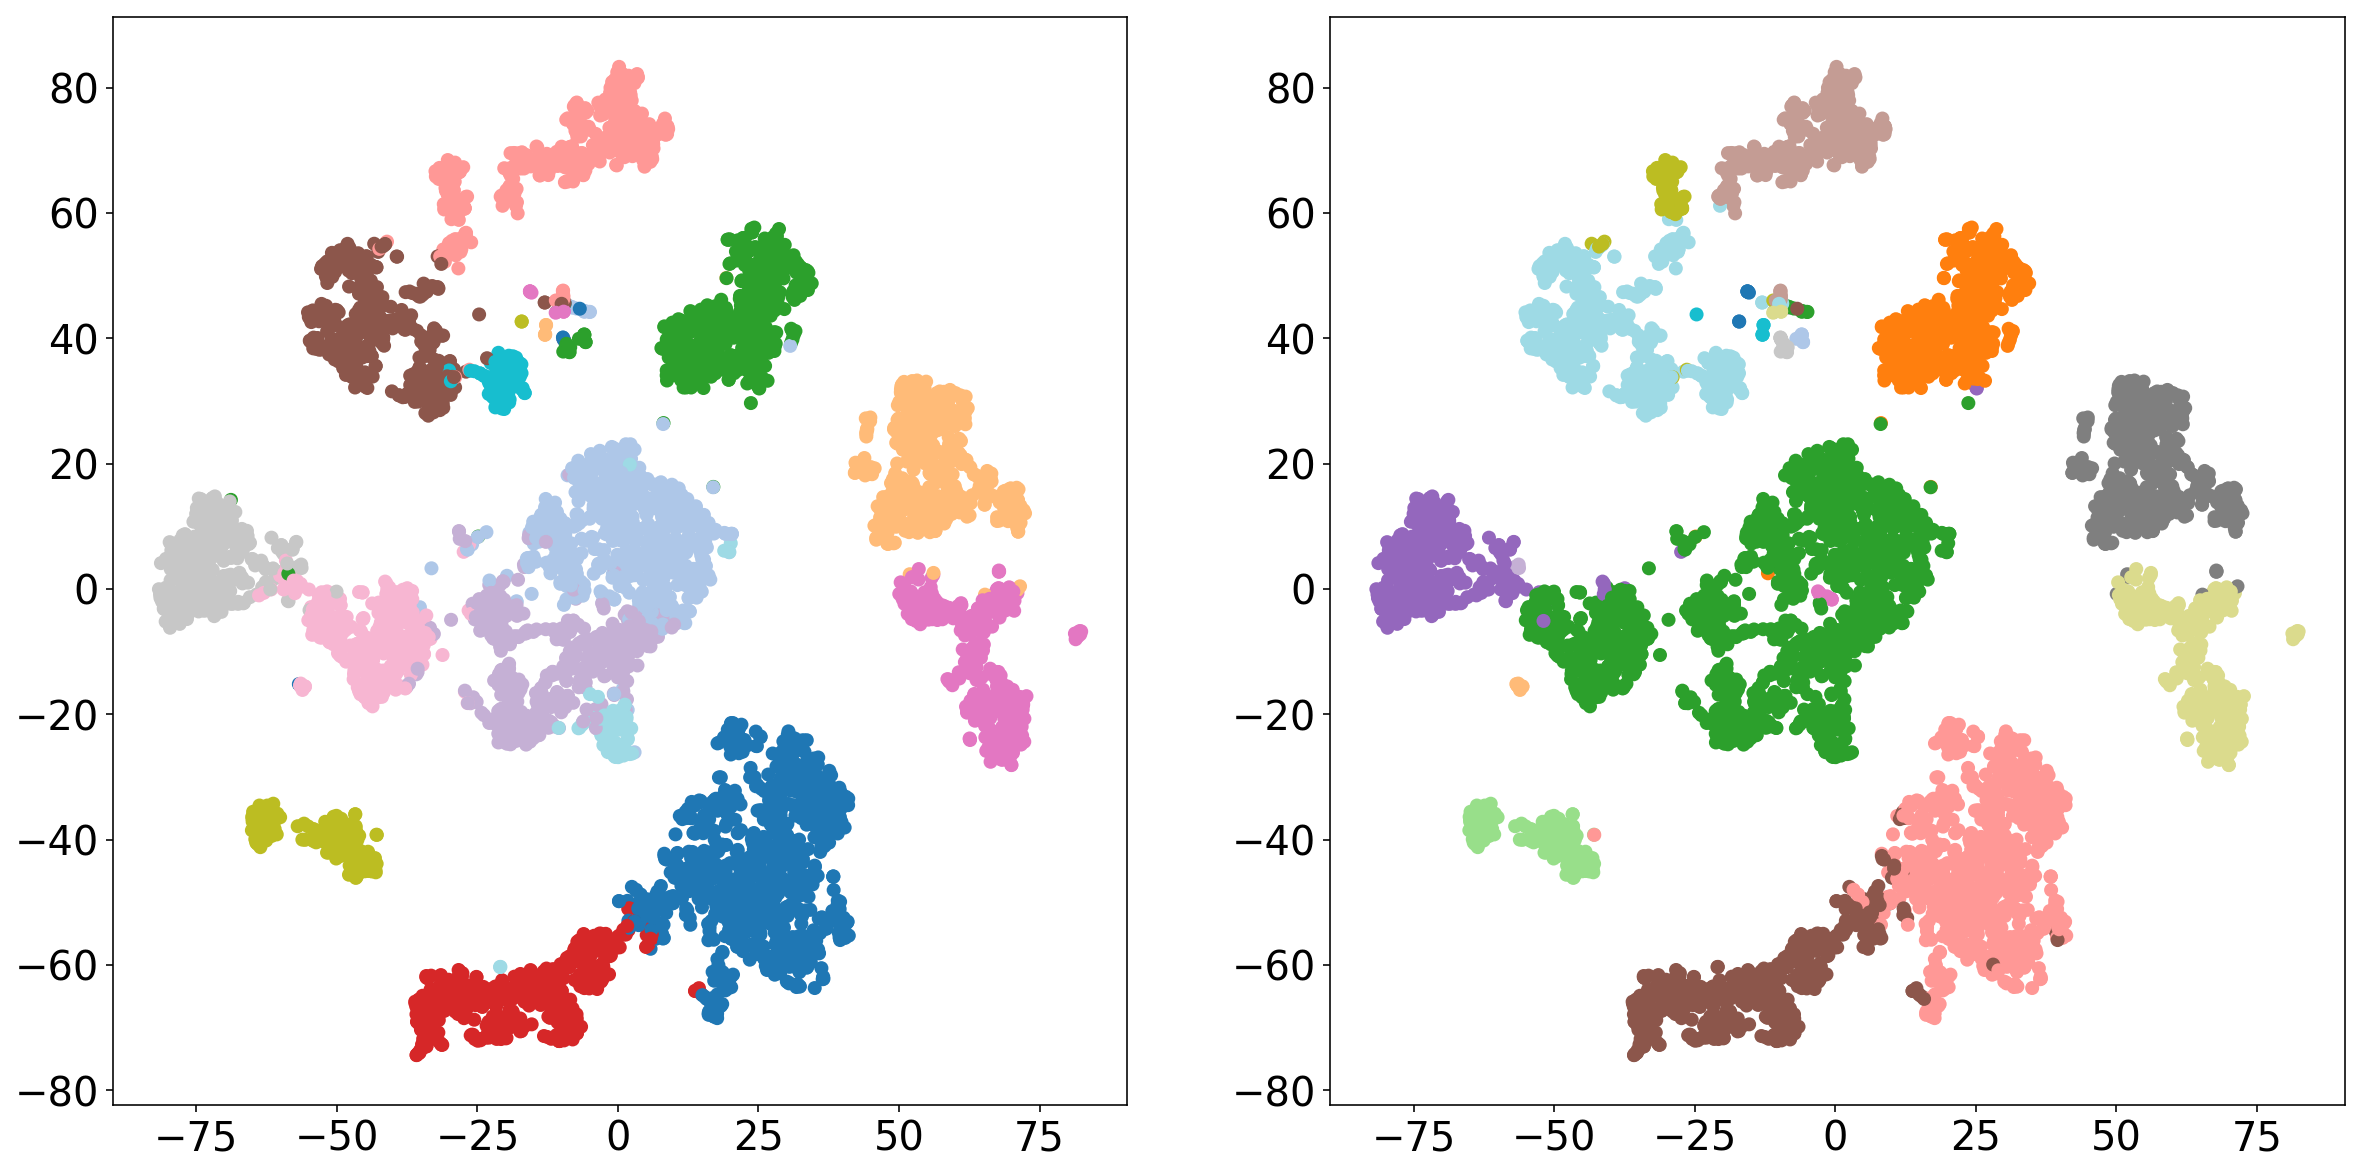

In [110]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

x = gene.obsm["X_pca_tsne"][:,0]
y = gene.obsm["X_pca_tsne"][:,1]
c = gene.obs["louvain"].astype(int)

ax[0].scatter(x, y, c = c, cmap='tab20')

x = gene.obsm["X_pca_tsne"][:,0]
y = gene.obsm["X_pca_tsne"][:,1]
c = gene.obs["subclass_id"].astype(int)

ax[1].scatter(x, y, c = c, cmap='tab20')

plt.show()

In [111]:
adjusted_rand_score(gene.obs["louvain"].values, gene.obs["subclass_id"].values)

0.6958632245045856

### TSNE on NCA (trained on subclass_labels)

In [112]:
print("Number of NCs: {}".format(num_NCA))

Number of NCs: 10


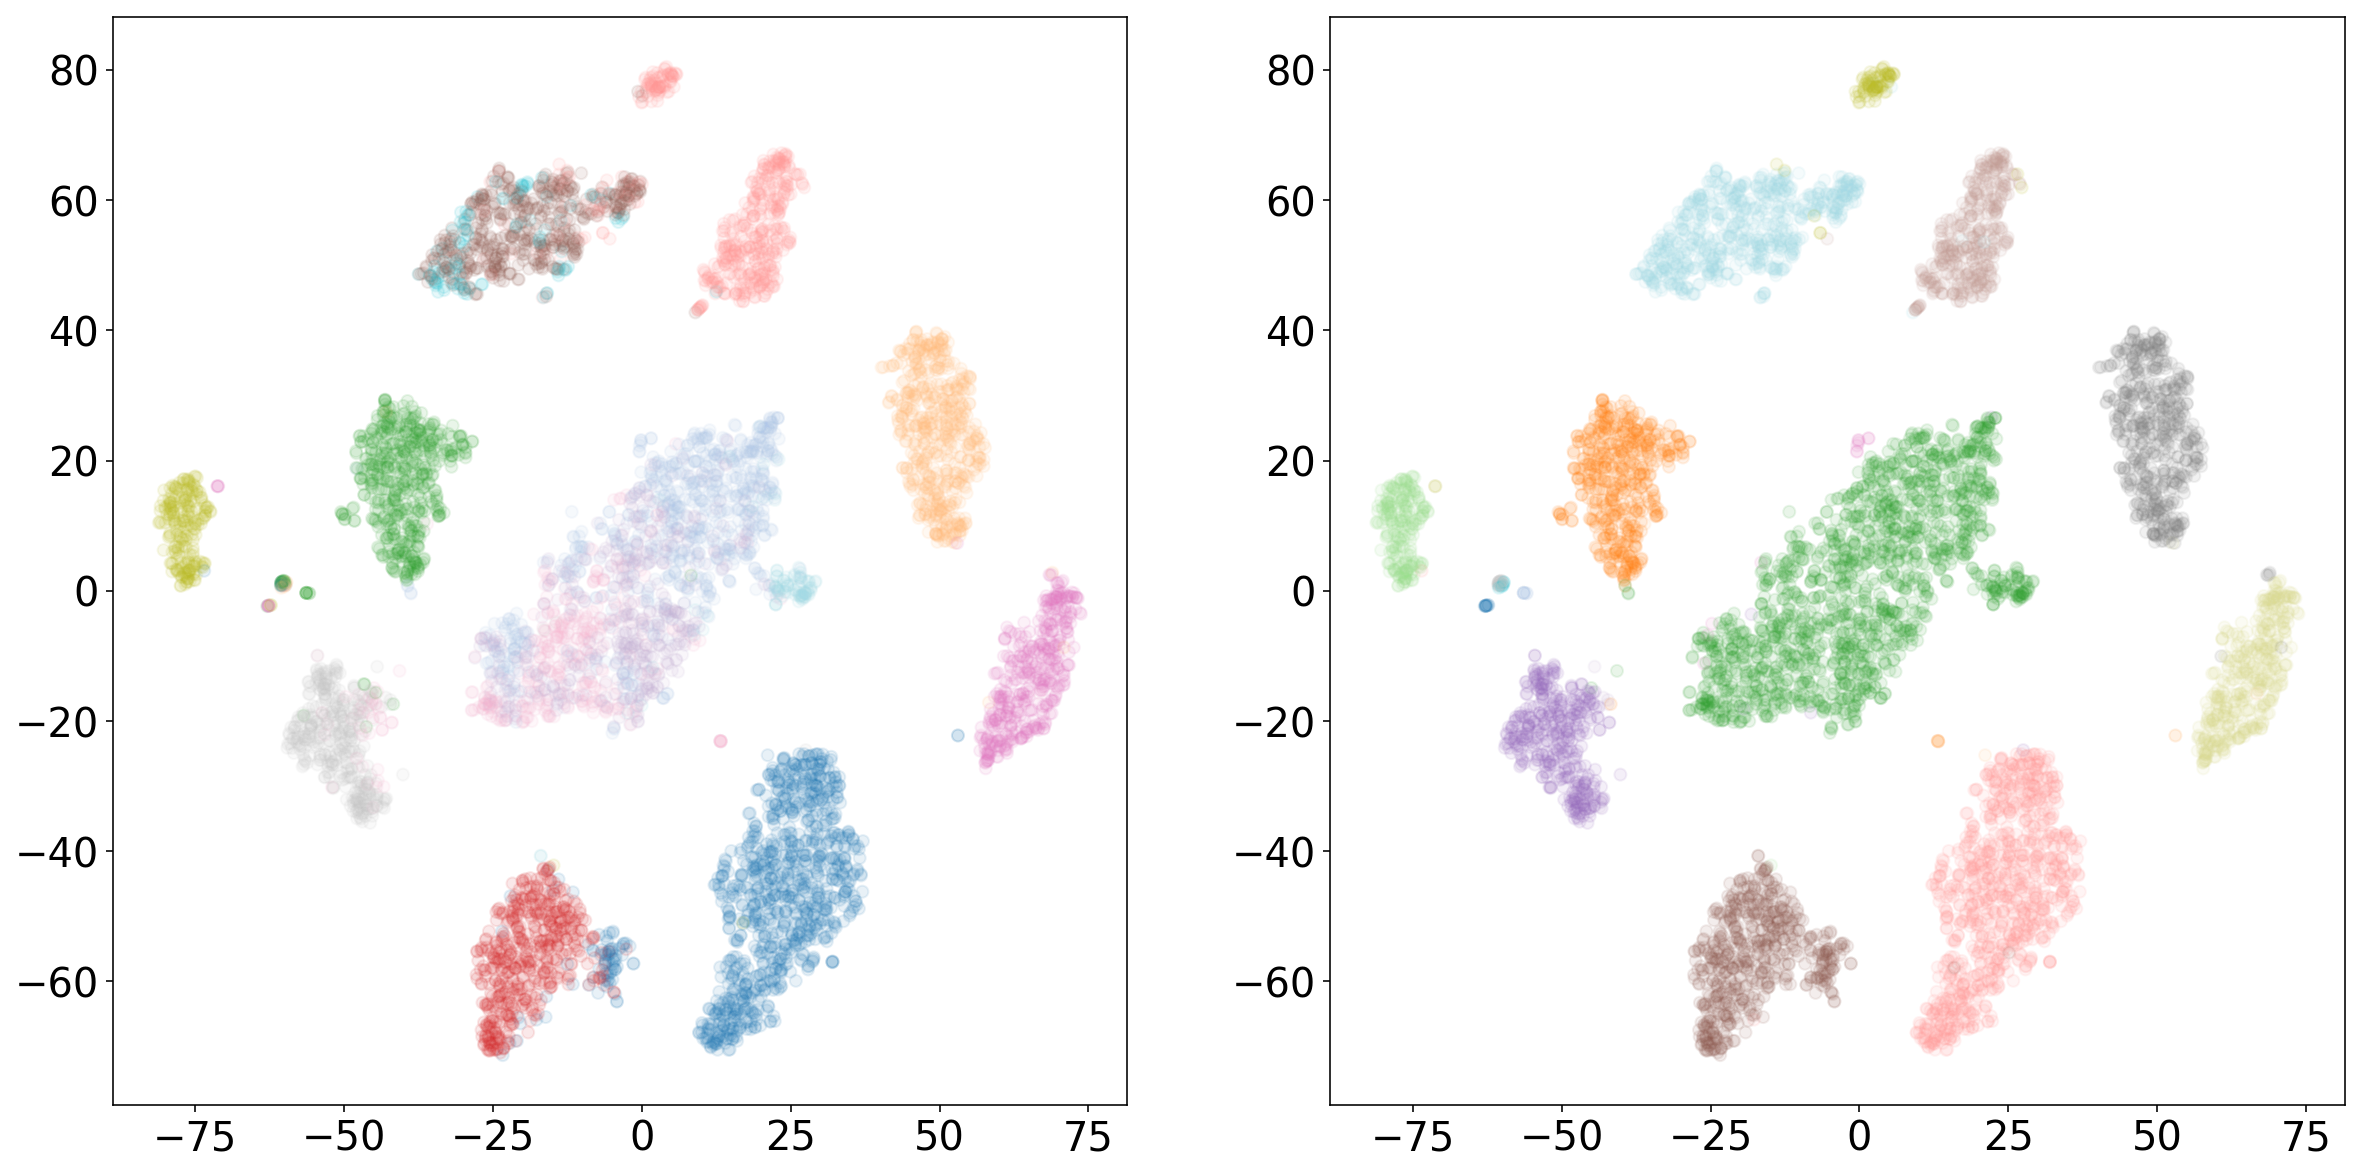

In [113]:
fig, ax = plt.subplots(figsize=(20,10), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["louvain"].astype(int)

ax[0].scatter(x, y, c = c, cmap='tab20', alpha=0.1)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_id"].astype(int)

ax[1].scatter(x, y, c = c, cmap='tab20', alpha=0.1)

plt.show()

# Annotate clusters

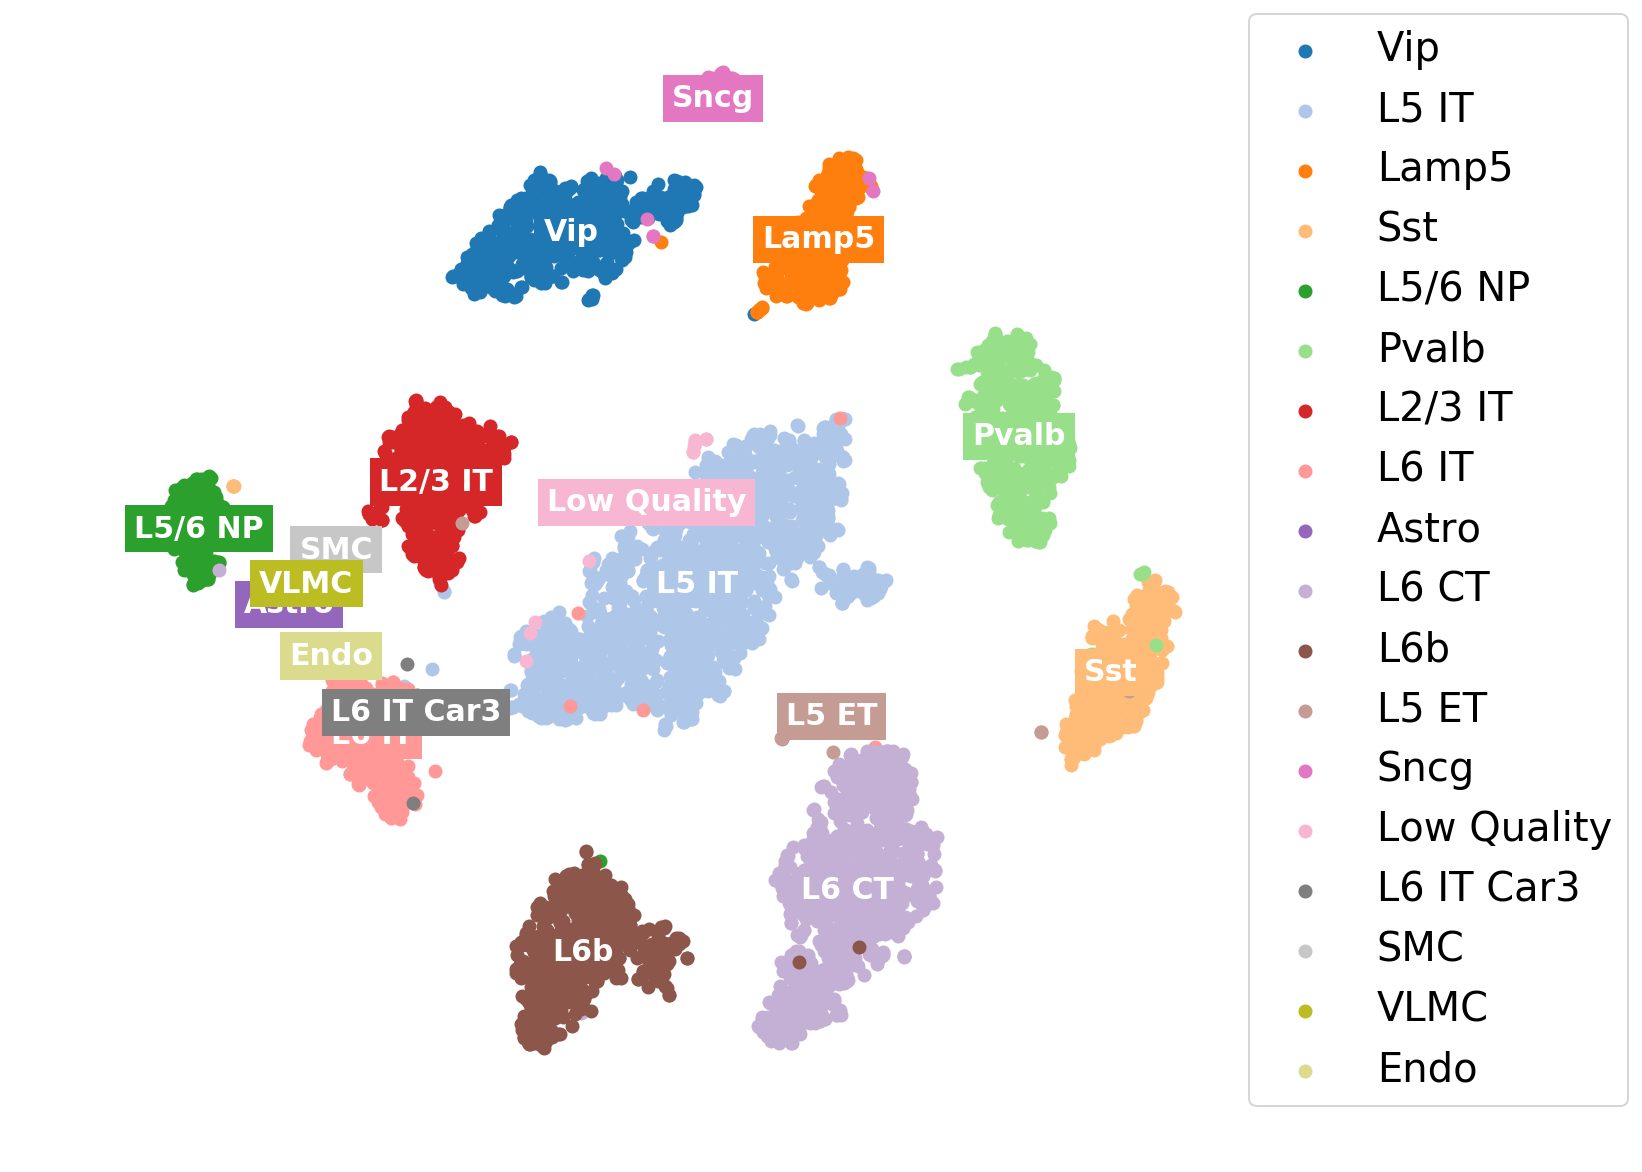

In [114]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    if cluster == "Endo": y = y-10
    if cluster == "SMC": y = y+5; x=x+5
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

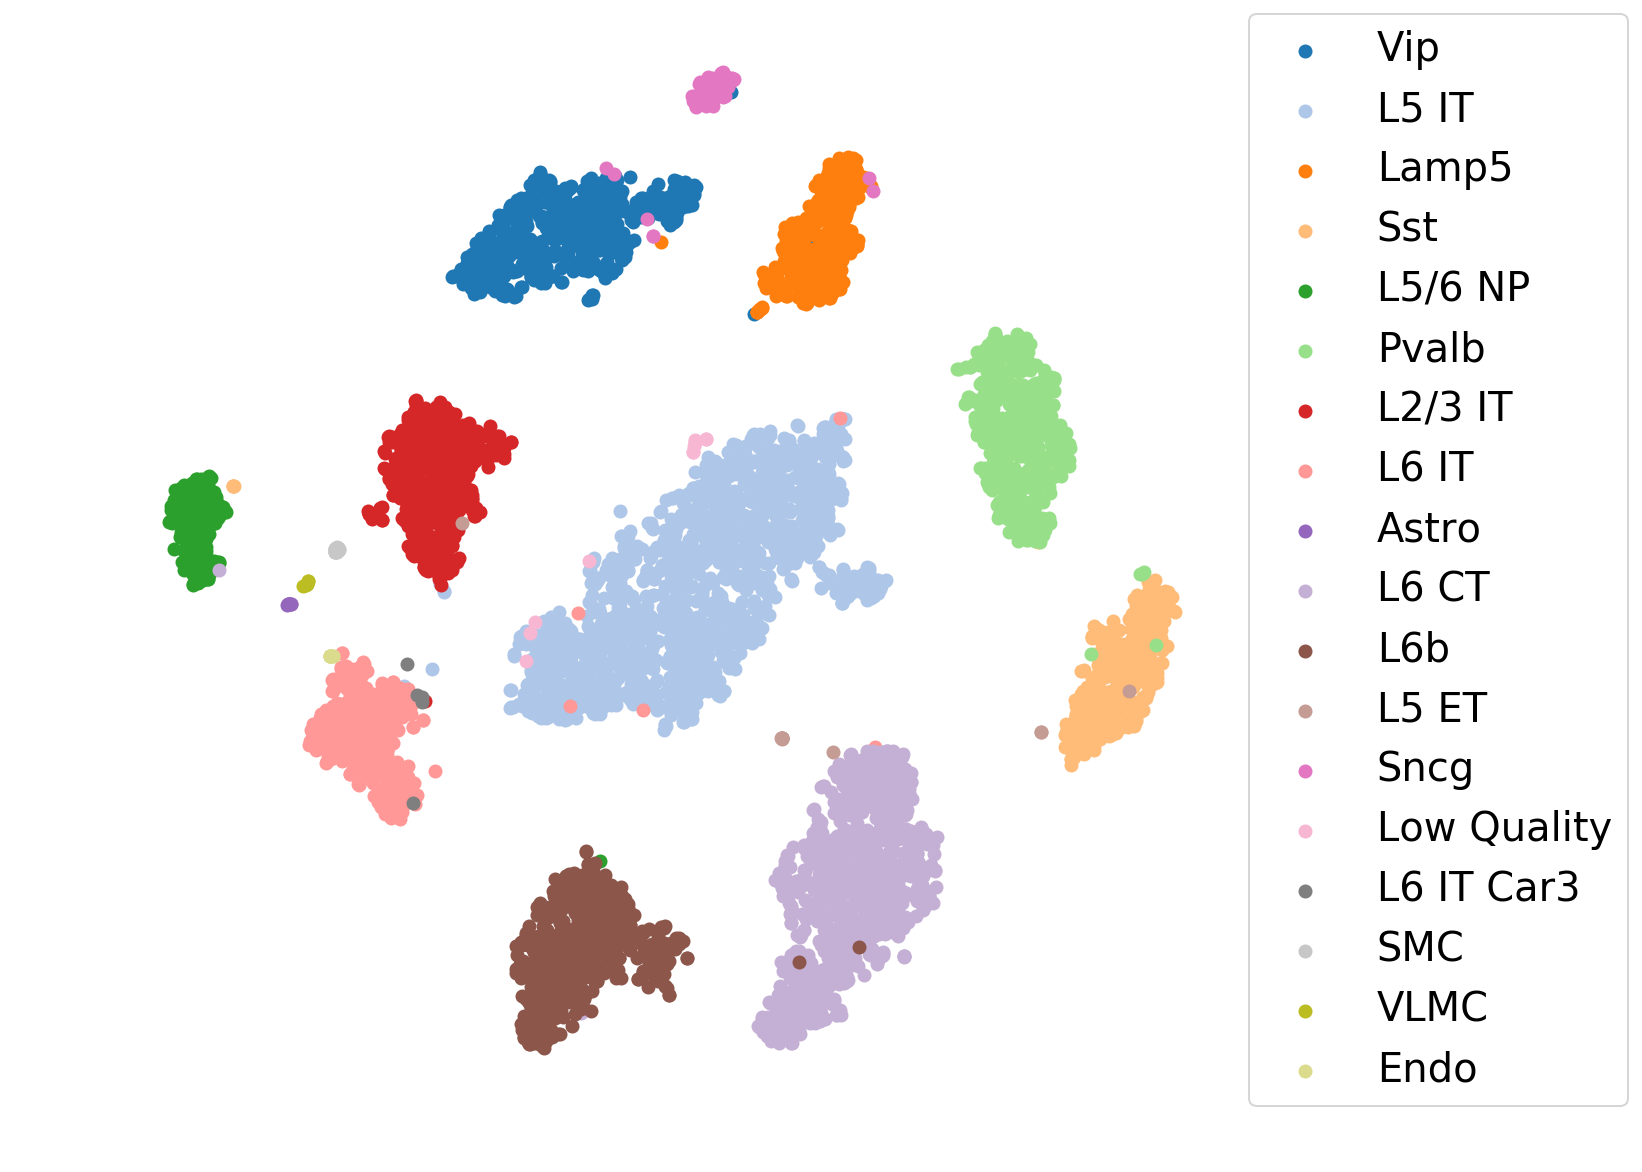

In [115]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    if cluster == "Endo": y = y-10
    if cluster == "SMC": y = y+5; x=x+5
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    #ax.annotate(cluster, 
    #         (np.mean(x), np.mean(y)),
    #         horizontalalignment='center',
    #         verticalalignment='center',
    #         size=15, weight='bold',
    #         color="white",
    #           backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

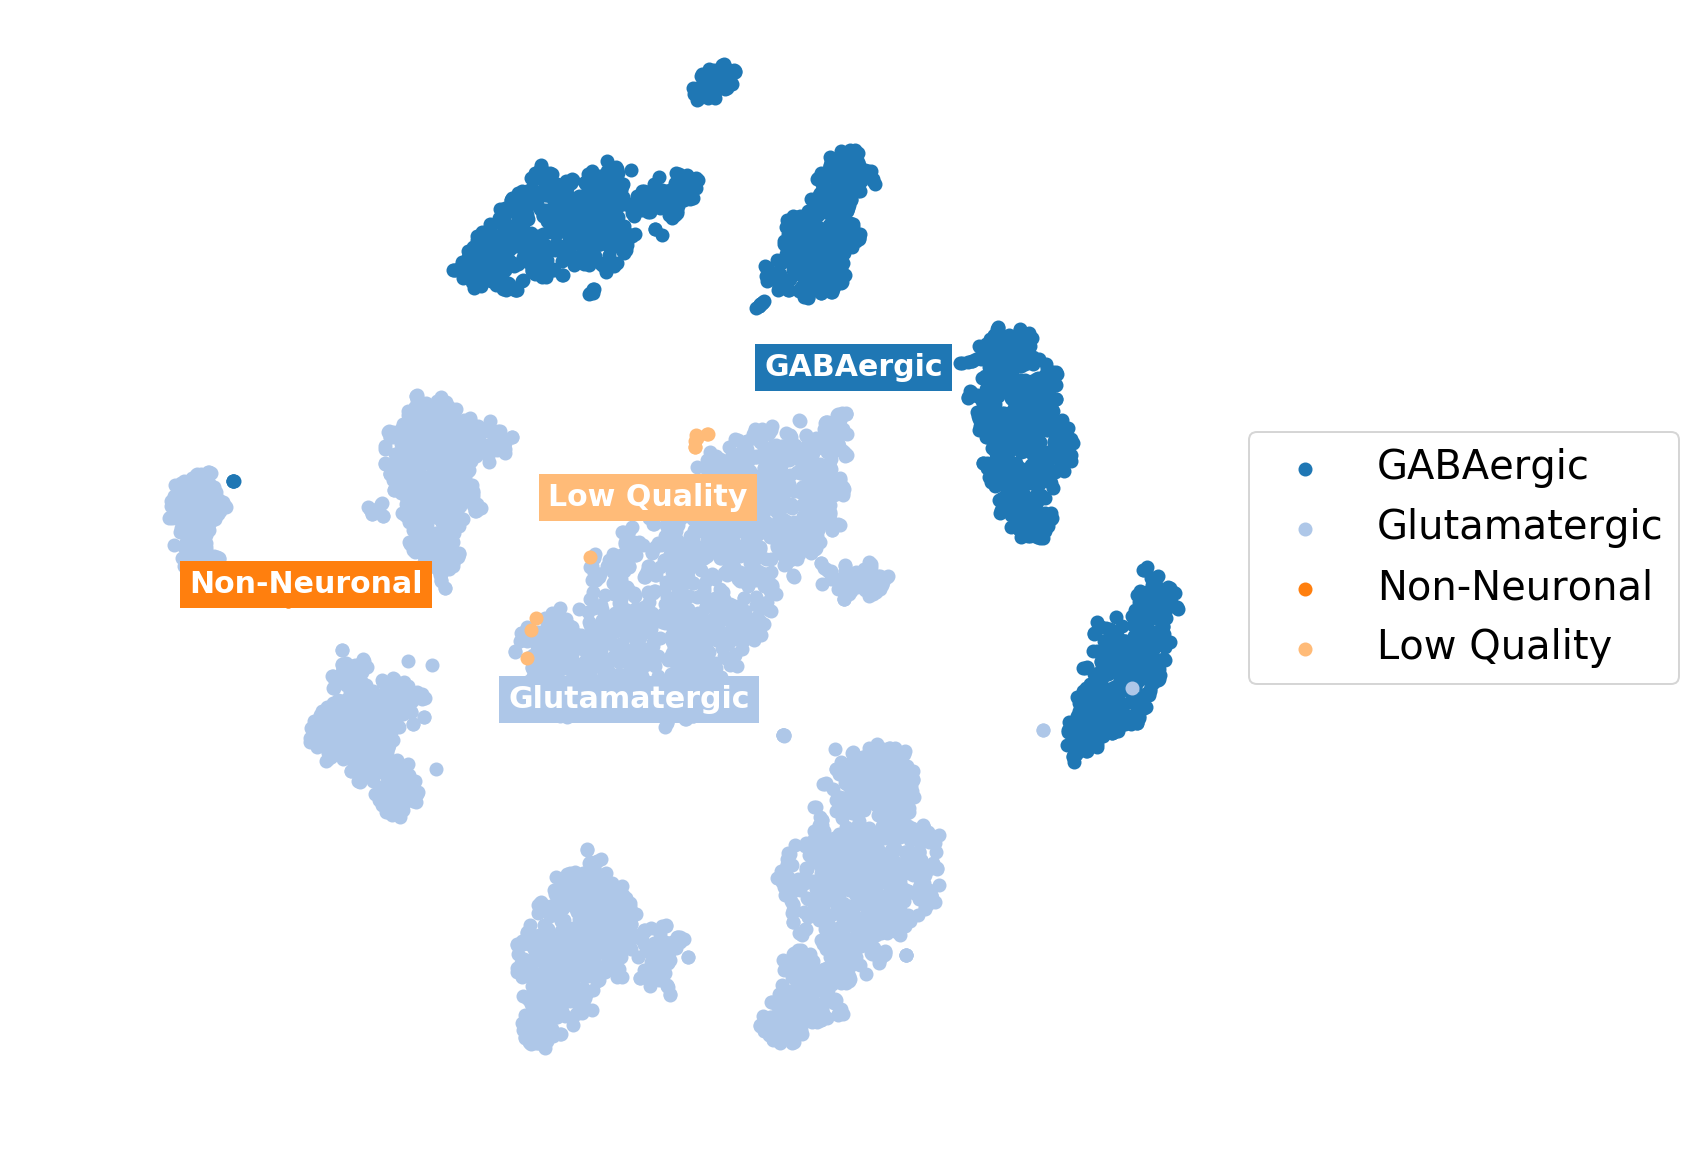

In [116]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["class_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.class_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

# Plotting expression of a gene and isoform

In [91]:
isof_exp

array(<6043x2 sparse matrix of type '<class 'numpy.float32'>'
	with 7579 stored elements in Compressed Sparse Row format>, dtype=object)

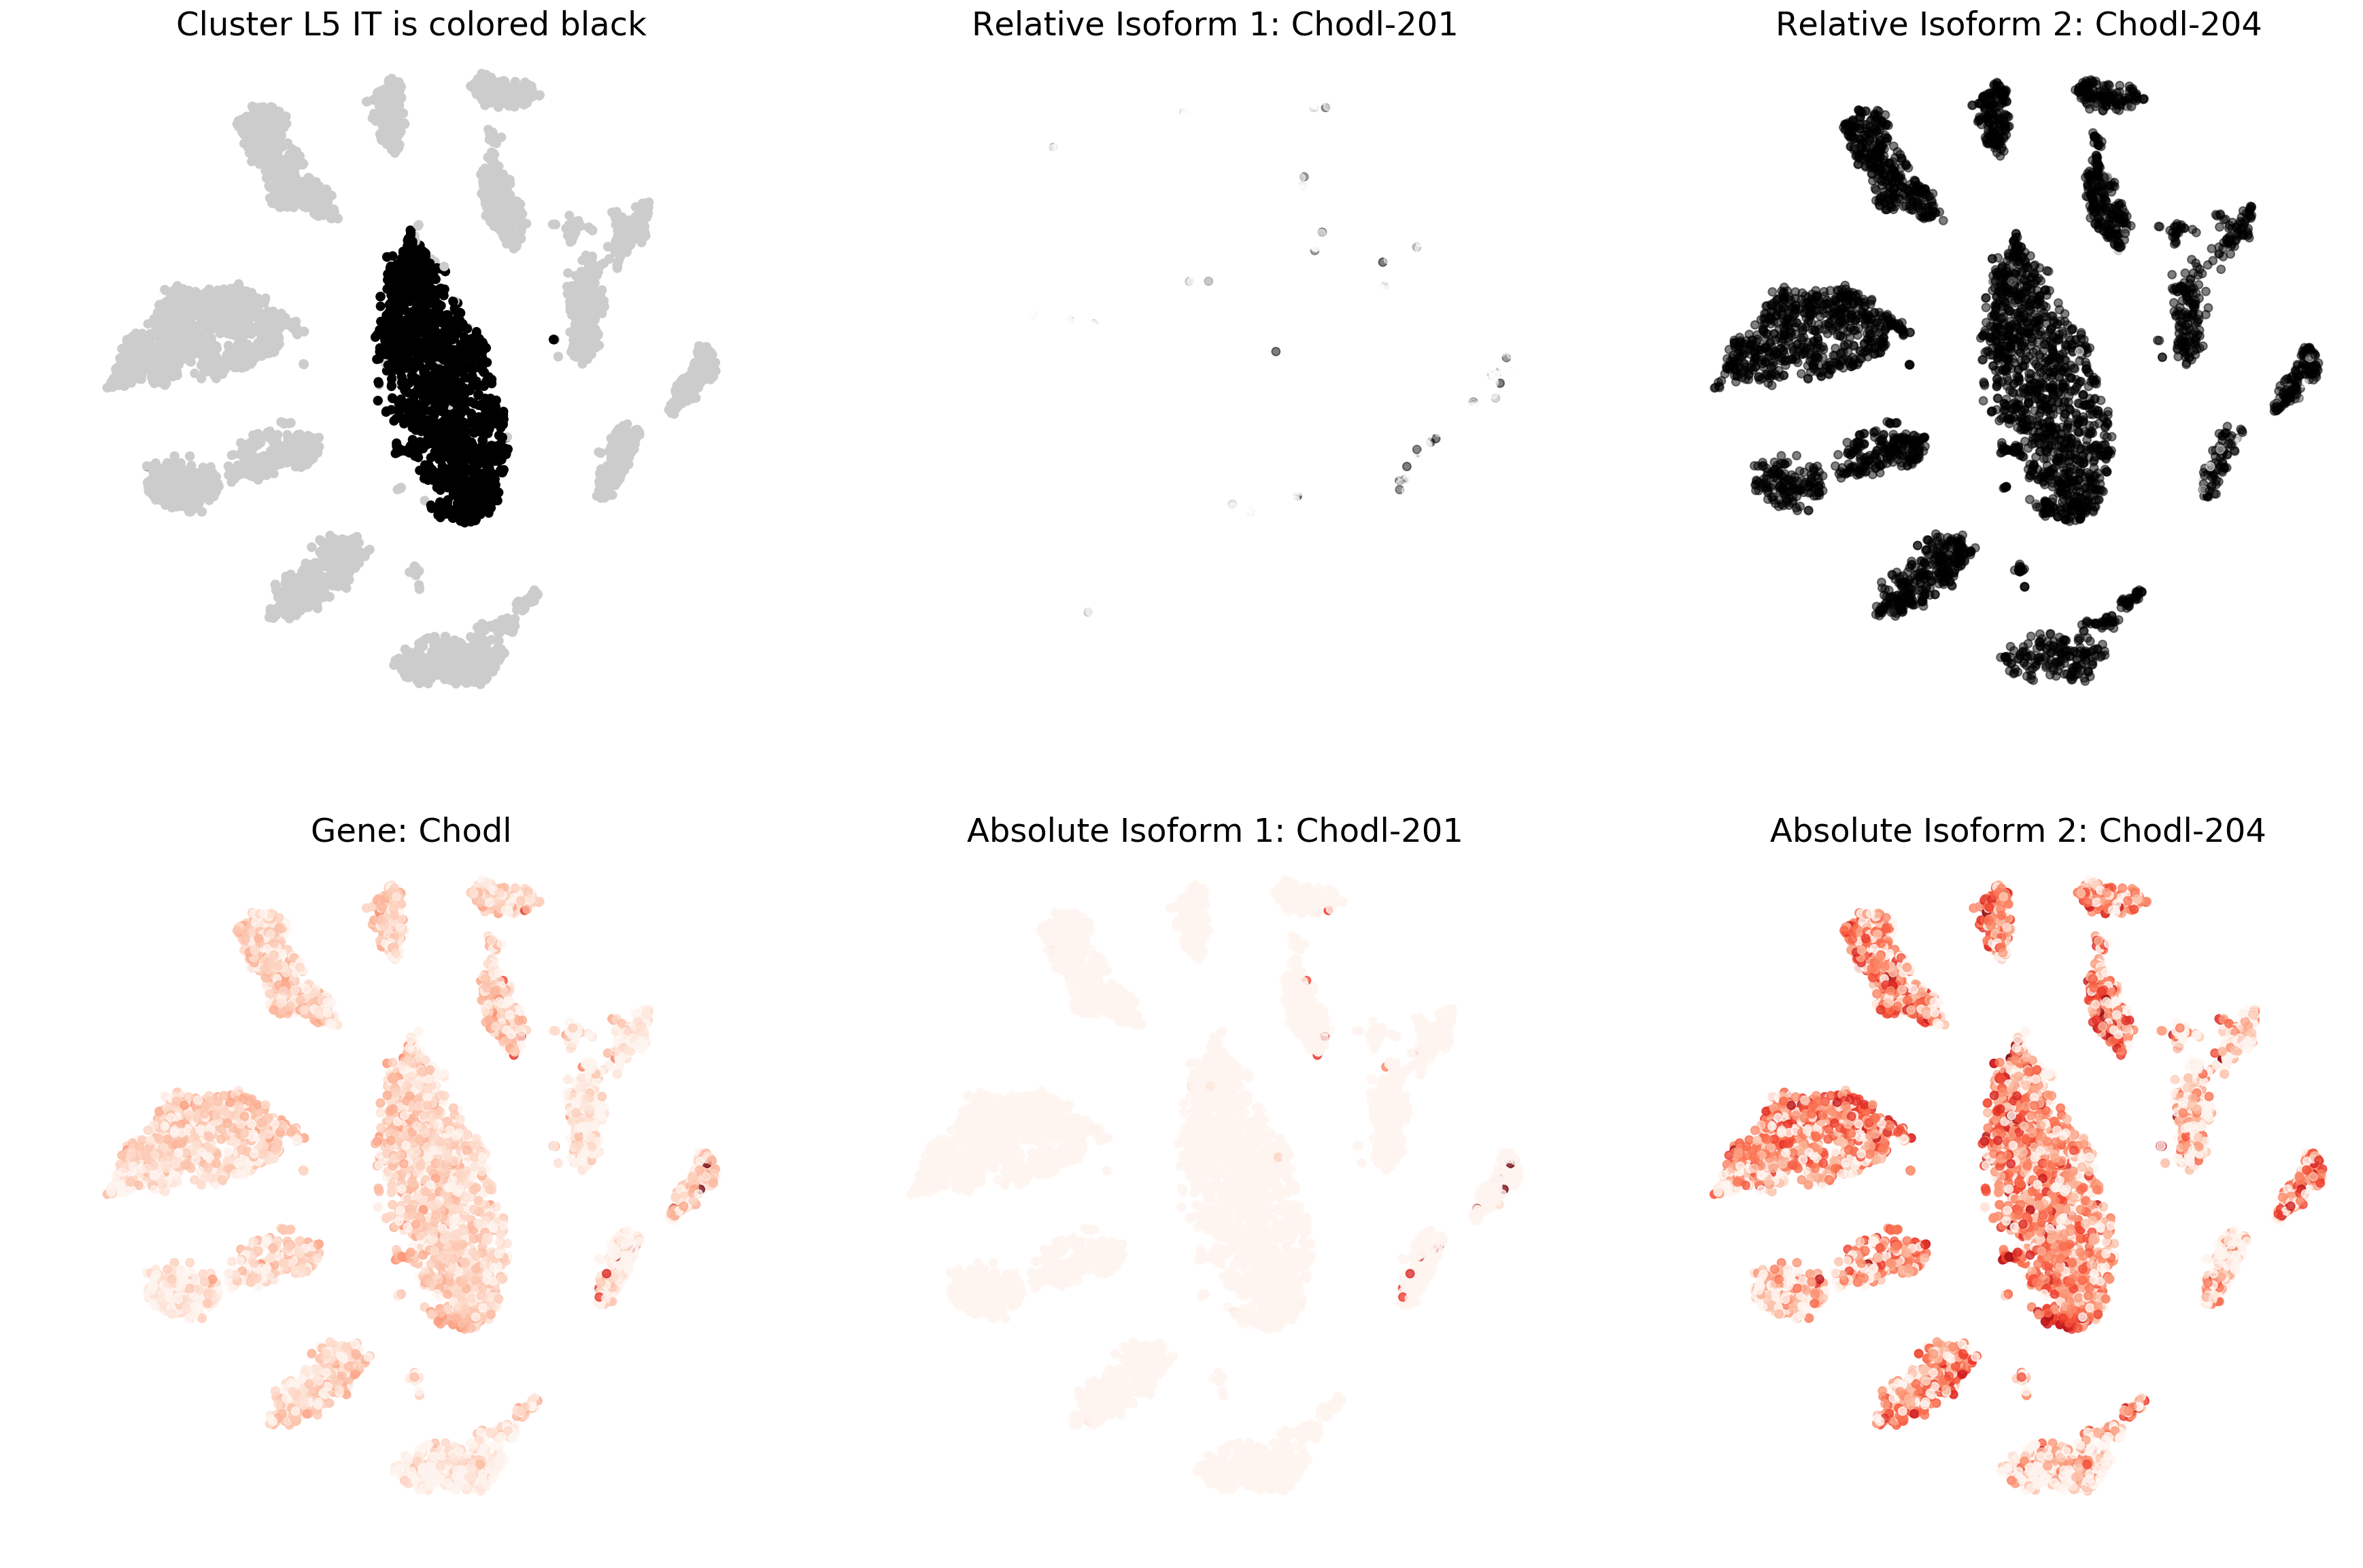

In [384]:
specific_gene = "Chodl" # Slfn3 from cnum 2 Fam19a5 Plcxd3

cnum = 4

assignments = isoform.obs.subclass_label.values
unique = np.unique(assignments)
cidx =unique[cnum]



gene_exp = np.asarray(gene[:, gene.var["gene_name"] == specific_gene].layers["log1p"]).reshape(-1)
isof_exp = np.asarray(isoform[:, isoform.var["gene_name"] == specific_gene].layers["log1p"].todense())

iso_1, iso_2 = isoform[:, isoform.var["gene_name"] == specific_gene].var.transcript_name.values


L1 = isof_exp.sum(axis=1)
norm = (isof_exp/L1[:,None])
#norm[np.isnan(norm)] = -1

fig, ax = plt.subplots(figsize=(30, 20), nrows=2, ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = assignments == unique[cnum]
#cells = gene.obs["subclass_label"] == str(cidx)

loc = ax[0,0]
sc = loc.scatter(x, y, c = c, cmap="nipy_spectral_r")
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=ax[0])
#cbar.set_ticks([])
loc.set_title("Cluster {} is colored black".format(cidx))

# Relative
loc = ax[0, 1]
c = norm[:,0]
idx = ~np.isnan(c)
sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
loc.set_axis_off()
# cbar = fig.colorbar(sc, ax=loc)
# cbar.set_ticks([])
loc.set_title("Relative Isoform 1: "+ iso_1)

loc = ax[0, 2]
c = norm[:,1]
idx = ~np.isnan(c)
sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
loc.set_axis_off()
# cbar = fig.colorbar(sc, ax=loc)
# cbar.set_ticks([])
loc.set_title("Relative Isoform 2: "+ iso_2)



cmap = "Reds"
# Gene Expression
loc = ax[1,0]
sc = loc.scatter(x, y, c = gene_exp, cmap=cmap, alpha=0.75)
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Gene: "+ specific_gene)


## Absolute
loc=ax[1, 1]
sc = loc.scatter(x, y, c = isof_exp[:,0], cmap=cmap, alpha=0.75)
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Absolute Isoform 1: "+ iso_1)



loc=ax[1,2]
sc = loc.scatter(x, y, c = isof_exp[:,1], cmap=cmap, alpha=0.75)

loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Absolute Isoform 2: "+ iso_2)



plt.show()

# Making histogram of expression of gene per cluster

In [367]:
specific_gene = "Chodl" # Slfn3 from cnum 2 Fam19a5Adamts2

In [377]:
c = "Sst"
x = gene[:,gene.var.gene_name == specific_gene][gene.obs.subclass_label == c].layers["log1p"][:,0]
y = gene[:,gene.var.gene_name == specific_gene][gene.obs.subclass_label != c].layers["log1p"][:,0]

In [378]:
cluster_exp = [x.mean(),y.mean()]

In [379]:
cluster_exp

[ArrayView(0.96186286, dtype=float32), ArrayView(1.017894, dtype=float32)]

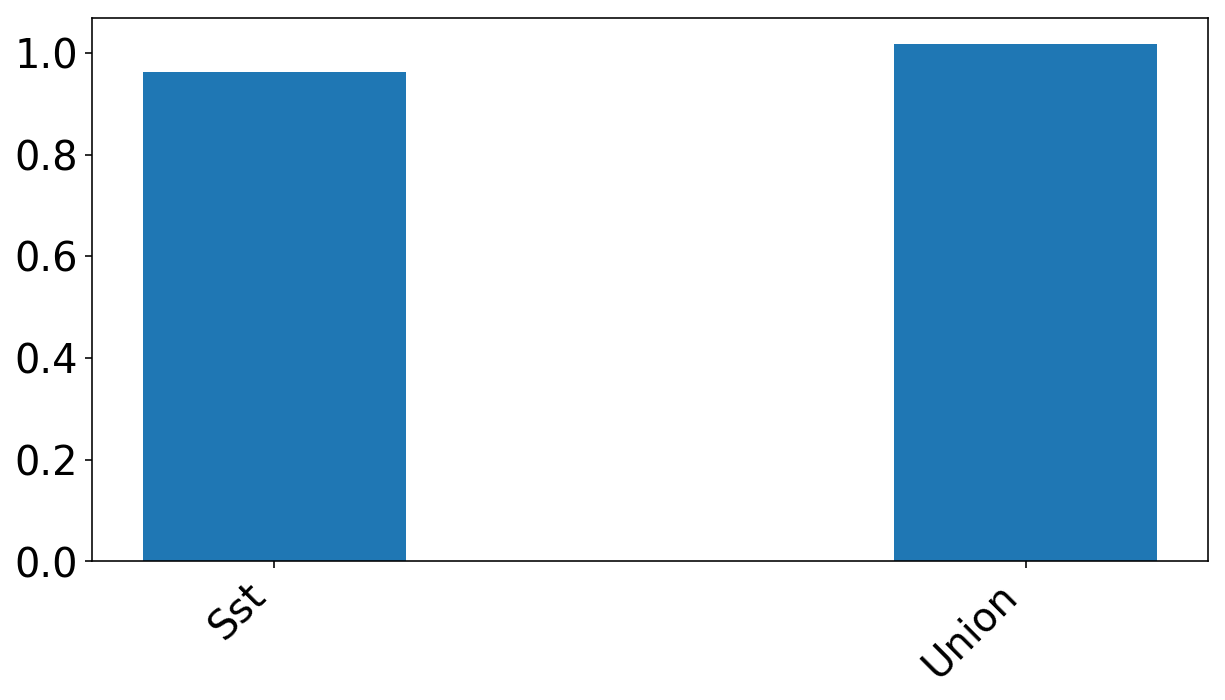

In [380]:
fig, ax = plt.subplots(figsize=(10,5))

labels = [c, "Union"]
lidx = np.arange(len(labels))  # the label locations

x = cluster_exp

width = 0.35  # the width of the bars

ax.bar(lidx, x, width)

ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.show()

In [387]:
adata.obs.cluster_label[adata.obs.cluster_label.str.contains("Chod")]

1014    Sst Chodl
1363    Sst Chodl
1942    Sst Chodl
4235    Sst Chodl
4392    Sst Chodl
4519    Sst Chodl
4528    Sst Chodl
5395    Sst Chodl
5554    Sst Chodl
5625    Sst Chodl
5639    Sst Chodl
5646    Sst Chodl
5889    Sst Chodl
6274    Sst Chodl
6469    Sst Chodl
6555    Sst Chodl
6574    Sst Chodl
Name: cluster_label, dtype: category
Categories (62, object): [Astro Aqp4, Endo Slc38a5, L2/3 IT Cdh13 Sla, L2/3 IT Macc1, ..., Vip Htr1f, Vip Igfbp6, Vip Lmo1, Vip Serpinf1]

In [381]:
# cluster_exp = np.zeros((unique.shape[0], 2))
# for cidx, c in enumerate(unique):
#     x = isoform[isoform.obs.subclass_label == c][:,isoform.var.gene_name == specific_gene].layers["log1p"].todense()
# 
# 
#     x = normalize_rows_L1(np.asarray(x))
#     
#     mask = np.asarray(x.sum(axis=1)>0).reshape(-1)
#     x = x[mask]
#     
#     m = x.mean(axis=0)
#     if m.shape[0] == 0:
#         m = np.array([np.nan, np.nan])
#         
#     cluster_exp[cidx] = m
    
c = "Sst"
x = isoform[:,isoform.var.gene_name == specific_gene][isoform.obs.subclass_label == c].layers["log1p"].todense()
y = isoform[:,isoform.var.gene_name == specific_gene][isoform.obs.subclass_label != c].layers["log1p"].todense()

x = normalize_rows_L1(np.asarray(x).reshape(-1, 2))
y = normalize_rows_L1(np.asarray(y).reshape(-1, 2))

x = x[~np.isnan(x[:,0])]
y = y[~np.isnan(y[:,0])]

In [382]:
cluster_exp_top = [x[:,1].mean(),y[:,1].mean()]
cluster_exp_bot = [x[:,0].mean(),y[:,0].mean()]

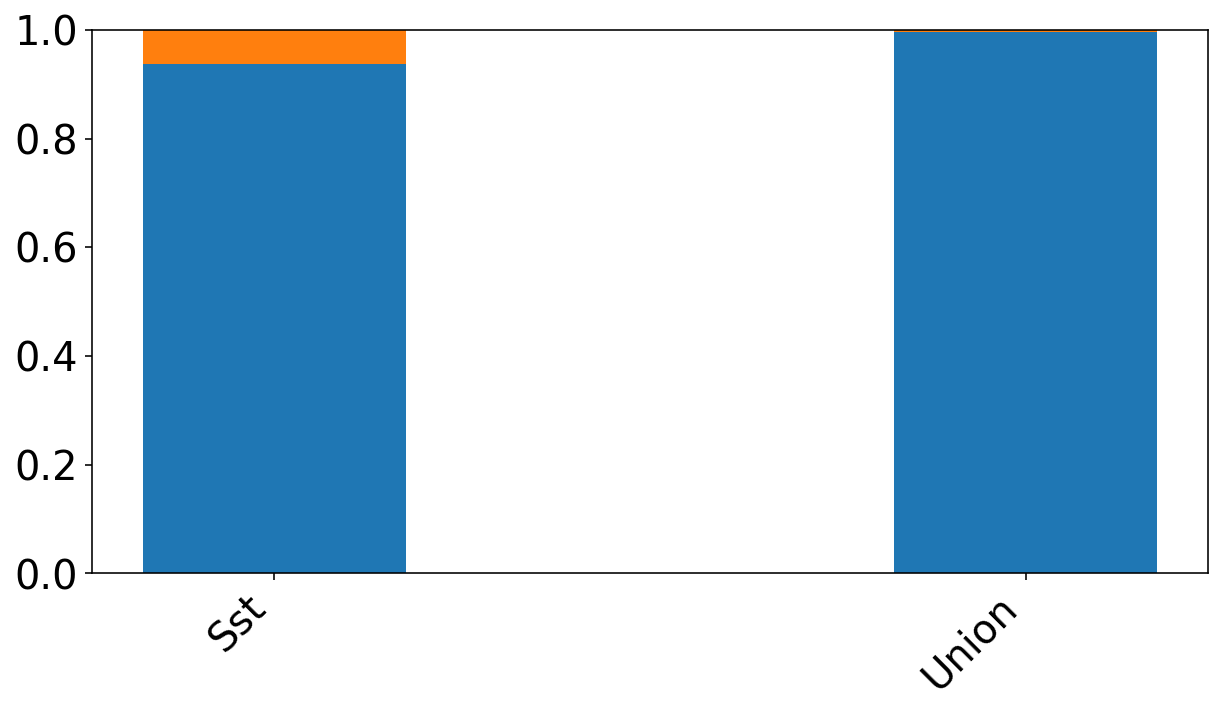

In [383]:
fig, ax = plt.subplots(figsize=(10,5))

labels = [c, "Union"]
lidx = np.arange(len(labels))  # the label locations

x = cluster_exp_top
y = cluster_exp_bot

width = 0.35  # the width of the bars

ax.bar(lidx, x, width)
ax.bar(lidx, y, width, bottom=x)

ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0,1)
plt.show()

In [366]:
m

array([0.6317394 , 0.36826068], dtype=float32)

In [245]:
cluster_exp

array([[       nan,        nan],
       [       nan,        nan],
       [0.85416579, 0.14583421],
       [0.28193545, 0.71806461],
       [0.41692629, 0.58307374],
       [0.20401302, 0.79598695],
       [0.6785804 , 0.32141957],
       [0.26422423, 0.73577553],
       [1.        , 0.        ],
       [0.14244191, 0.85755819],
       [0.69065785, 0.30934209],
       [       nan,        nan],
       [0.10477016, 0.89522988],
       [0.75000179, 0.2499982 ],
       [0.38816527, 0.6118347 ],
       [0.18435892, 0.81564105],
       [       nan,        nan],
       [0.63173938, 0.36826068]])

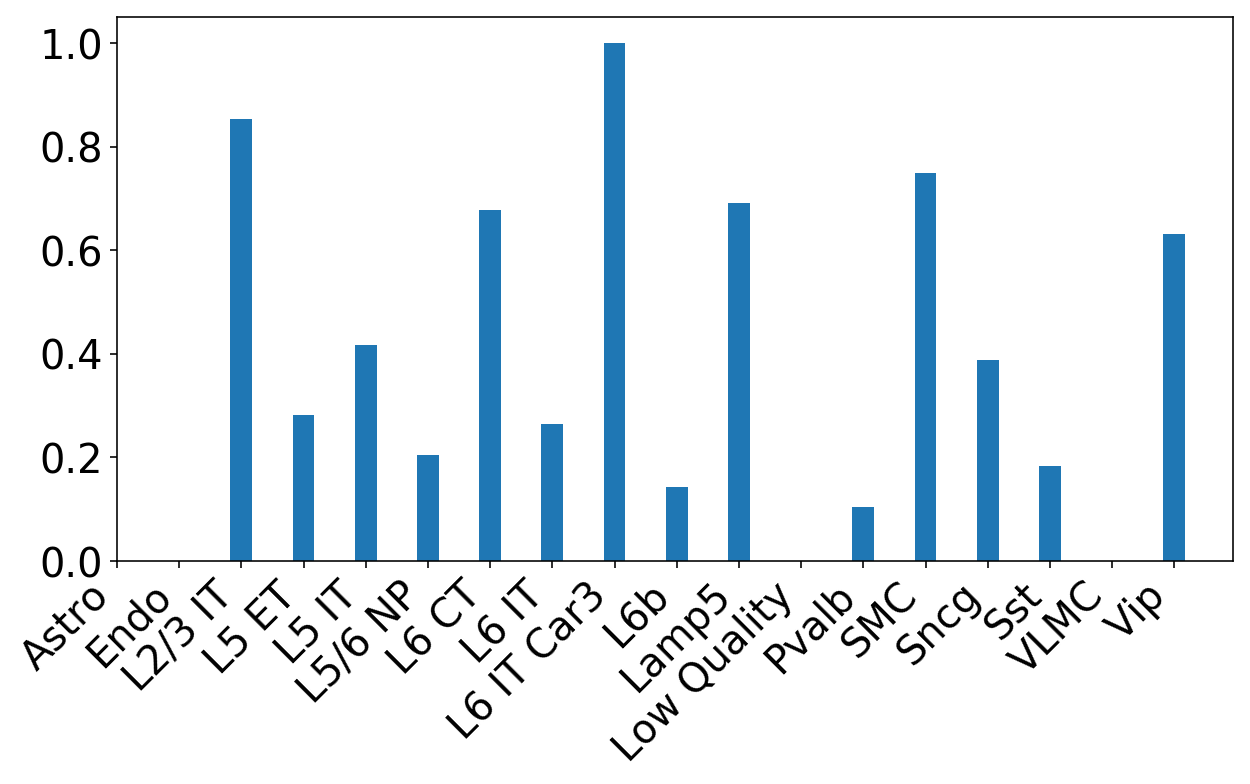

In [247]:
fig, ax = plt.subplots(figsize=(10,5))

labels = unique
lidx = np.arange(len(labels))  # the label locations

#x = normalize_rows_L1(cluster_exp)[:,1]

x = cluster_exp[:,0]

width = 0.35  # the width of the bars

ax.bar(lidx, x, width, label='Isoform 1')

ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.show()

In [104]:
cluster_exp

array([0.00000000e+00, 0.00000000e+00, 1.86667130e+02, 1.32455139e+01,
       2.53000464e+03, 8.32998169e+02, 5.68372681e+02, 6.52892456e+02,
       1.80121803e+00, 2.23304126e+03, 1.12086502e+02, 0.00000000e+00,
       1.93889050e+03, 1.79180121e+00, 9.12509689e+01, 8.99989075e+02,
       0.00000000e+00, 2.63825256e+02])

Want to implement this but for isoform switches, return the sets of genes whos isoform switches are highly variable

Then from that we want to look for the genes with highly variable isoform switches but not highly variable genes

This will give us a set of genes who;s isoforms are interesting

In [87]:
unique

array(['Astro', 'Endo', 'L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Pvalb',
       'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object)

In [83]:
def plot_level_2(gene, isoform, specific_gene, cluster, ax=None):

    cnum = cluster
    cname = cluster
    
    assignments = isoform.obs.subclass_label.values
    unique = np.unique(assignments)
    
    if type(cluster)==str:
        cnum = np.where(unique==cluster)
        cname = cluster
    #cidx =unique[cnum]
    

    
    gene_exp = np.asarray(gene[:, gene.var["gene_name"] == specific_gene].layers["log1p"].todense()).reshape(-1)
    isof_exp = np.asarray(isoform[:, isoform.var["gene_name"] == specific_gene].layers["log1p"].todense())
    
    iso_1, iso_2 = isoform[:, isoform.var["gene_name"] == specific_gene].var.transcript_name.values
    
    
    L1 = isof_exp.sum(axis=1)
    norm = (isof_exp/L1[:,None])
    #norm[np.isnan(norm)] = -1
    
    
    
    x = gene.obsm["X_nca_tsne"][:,0]
    y = gene.obsm["X_nca_tsne"][:,1]
    c = assignments == unique[cnum]
    c = gene.obs["subclass_id"].astype(int)
    
    loc = ax[0,0]
    sc = loc.scatter(x, y, c = c, cmap="tab20b")#cmap="nipy_spectral_r")
    loc.set_axis_off()
    #cbar = fig.colorbar(sc, ax=ax[0])
    #cbar.set_ticks([])
    # loc.set_title("Cluster {} is colored black".format(cname))
    loc.set_title("Clusters".format(cname))
    
    # Relative
    loc = ax[0, 1]
    c = norm[:,0]
    idx = ~np.isnan(c)
    sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
    loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
    loc.set_axis_off()
    # cbar = fig.colorbar(sc, ax=loc)
    # cbar.set_ticks([])
    loc.set_title("Relative Isoform 1: "+ iso_1)
    
    loc = ax[0, 2]
    c = norm[:,1]
    idx = ~np.isnan(c)
    sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
    loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
    loc.set_axis_off()
    # cbar = fig.colorbar(sc, ax=loc)
    # cbar.set_ticks([])
    loc.set_title("Relative Isoform 2: "+ iso_2)
    
    
    
    cmap = "Reds"
    # Gene Expression
    loc = ax[1,0]
    sc = loc.scatter(x, y, c = gene_exp, cmap=cmap, alpha=0.75)
    loc.set_axis_off()
    #cbar = fig.colorbar(sc, ax=loc, pad=0)
    #cbar.set_ticks([])
    loc.set_title("Gene: "+ specific_gene)
    
    
    ## Absolute
    loc=ax[1, 1]
    sc = loc.scatter(x, y, c = isof_exp[:,0], cmap=cmap, alpha=0.75)
    loc.set_axis_off()
    #cbar = fig.colorbar(sc, ax=loc, pad=0)
    #cbar.set_ticks([])
    loc.set_title("Absolute Isoform 1: "+ iso_1)
    
    
    
    loc=ax[1,2]
    sc = loc.scatter(x, y, c = isof_exp[:,1], cmap=cmap, alpha=0.75)
    
    loc.set_axis_off()
    #cbar = fig.colorbar(sc, ax=loc, pad=0)
    #cbar.set_ticks([])
    loc.set_title("Absolute Isoform 2: "+ iso_2)
    
    
    return ax

AttributeError: 'ArrayView' object has no attribute 'todense'

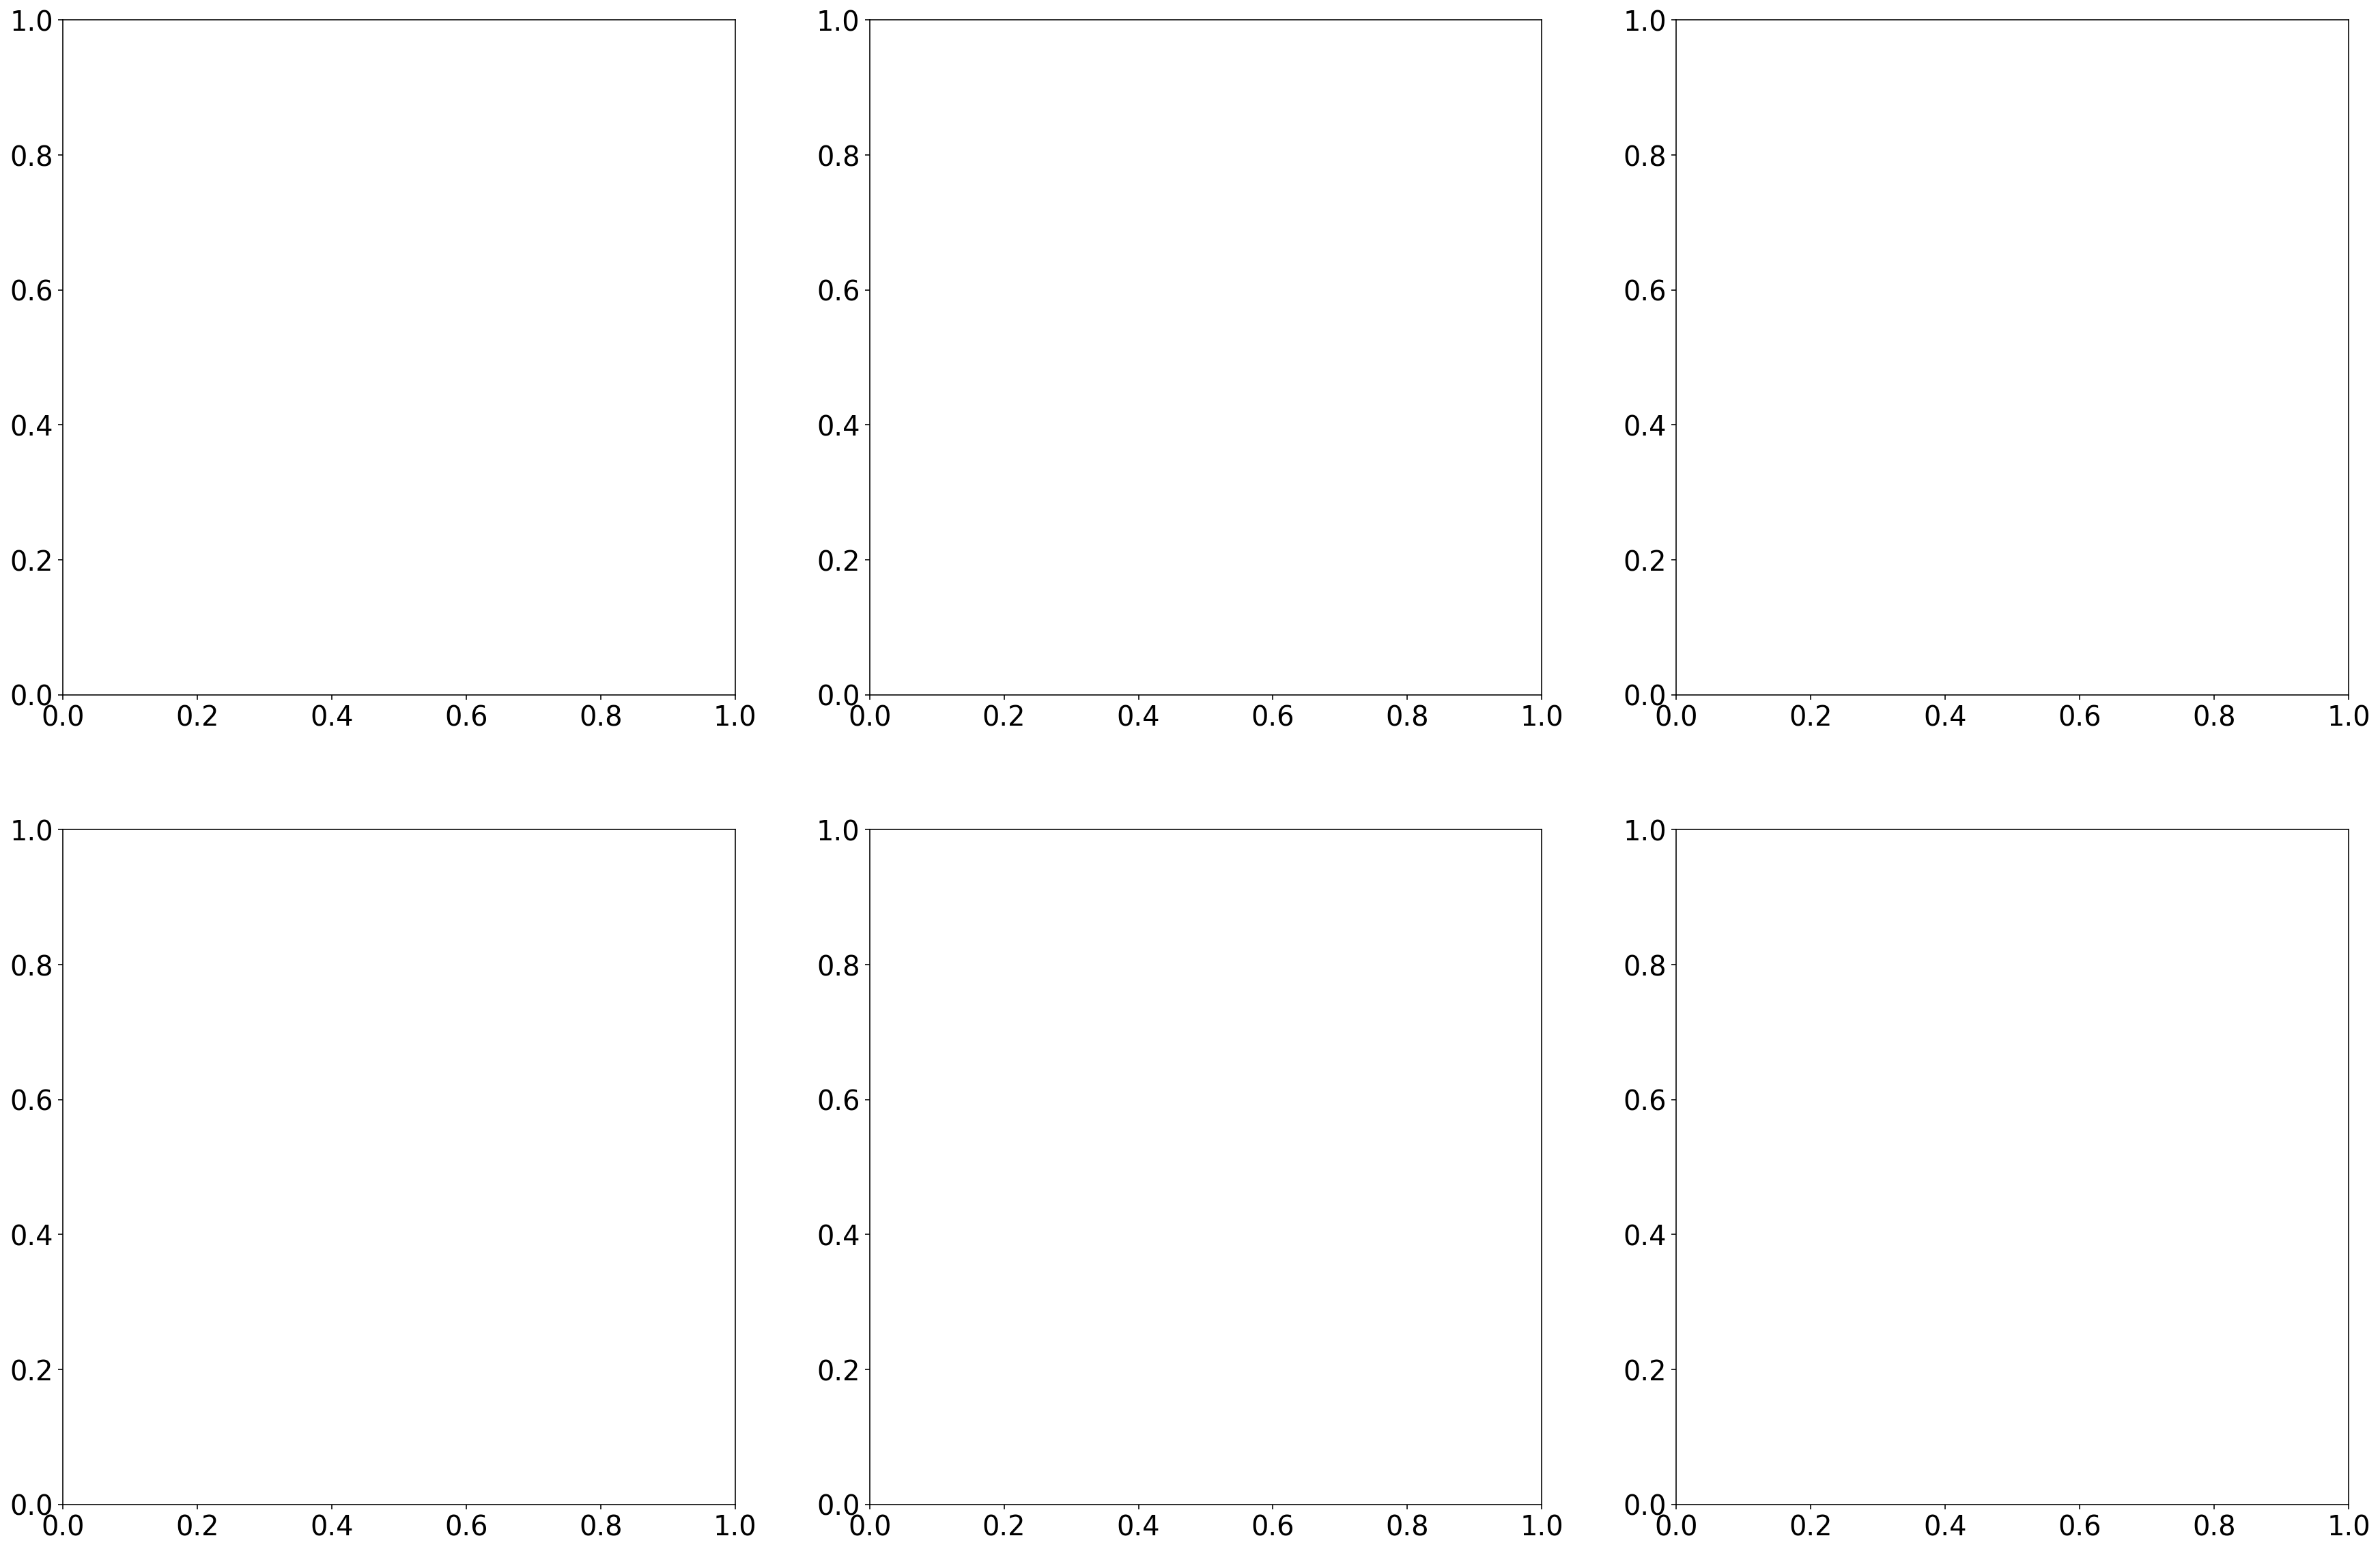

In [84]:
specific_gene = "Fam19a5" # Slfn3 from cnum 2 Fam19a5 Rragb

fig, ax = plt.subplots(figsize=(30, 20), nrows=2, ncols=3)
plot_level_2(gene, isoform, specific_gene, "Vip", ax=ax)
plt.show()

In [121]:
targets = np.array(['Lactb2', 'Hs6st1', 'Aox1', 'C530043A13Rik', 'Itpkb', 'Gm13522',
       'Bmf', 'Rragb', '2700069I18Rik', '4632415L05Rik', 'Kcnn3',
       'Gm17690', 'Hadh', 'Wwp1', 'Mob3b', 'Spaar', 'Tmem35b', 'Selenon',
       'Clic4', 'Cdc42', 'Agtrap', 'Casz1', '4921504A21Rik',
       '4930522L14Rik', '1500011B03Rik', 'Fbxw8', 'Zan', 'Flt3', 'Gpr37',
       'Nap1l5', 'Ndnf', 'Gm36816', 'Oxtr', 'Snrpn', 'Gm44812', 'Gm16638',
       'Gm10605', 'Dchs1', 'Pycard', 'Vip', 'Gm47512', 'Gm9803', 'Slc1a6',
       'Ccdc38', 'Eif4ebp1', 'C130073E24Rik', 'Gm15991', 'Sh2d4a',
       '0610038B21Rik', 'Gm20163', 'A430057M04Rik', 'Mmp14',
       '9430037G07Rik', 'Gm16010', '4921534H16Rik', 'Trex1', 'Aspa',
       'Nme2', 'Itgb3', 'Txndc15', 'Fkbp1b', 'Osr1', 'Sgpp1', 'Gon7',
       'Gm10389', 'Angpt1', 'Tst', 'Sult4a1', 'Fam19a5', 'Prickle1',
       'Emp2', 'Gap43', 'Gng13', 'Cenpq', 'Bin1', '3222401L13Rik', 'Gnal',
       'Zfp516'], dtype=object)

In [123]:
%%time
l = targets.shape[0]
for tidx, t in enumerate(targets):
    print("{} of {} genes plotted".format(tidx, l))
    fig, ax = plt.subplots(figsize=(30, 20), nrows=2, ncols=3)
    ax = plot_level_2(gene, isoform, t, "Vip", ax=ax)
    plt.savefig("/home/sina/projects/mop/analysis/cell_ranger_annotation/target_genes/{}.png".format(t))
    plt.close()

0 of 78 genes plotted
1 of 78 genes plotted
2 of 78 genes plotted
3 of 78 genes plotted
4 of 78 genes plotted
5 of 78 genes plotted
6 of 78 genes plotted
7 of 78 genes plotted
8 of 78 genes plotted
9 of 78 genes plotted
10 of 78 genes plotted
11 of 78 genes plotted
12 of 78 genes plotted
13 of 78 genes plotted
14 of 78 genes plotted
15 of 78 genes plotted
16 of 78 genes plotted
17 of 78 genes plotted
18 of 78 genes plotted
19 of 78 genes plotted
20 of 78 genes plotted
21 of 78 genes plotted
22 of 78 genes plotted
23 of 78 genes plotted
24 of 78 genes plotted
25 of 78 genes plotted
26 of 78 genes plotted
27 of 78 genes plotted
28 of 78 genes plotted
29 of 78 genes plotted
30 of 78 genes plotted
31 of 78 genes plotted
32 of 78 genes plotted
33 of 78 genes plotted
34 of 78 genes plotted
35 of 78 genes plotted
36 of 78 genes plotted
37 of 78 genes plotted
38 of 78 genes plotted
39 of 78 genes plotted
40 of 78 genes plotted
41 of 78 genes plotted
42 of 78 genes plotted
43 of 78 genes plotte

# Plotting just gene expression

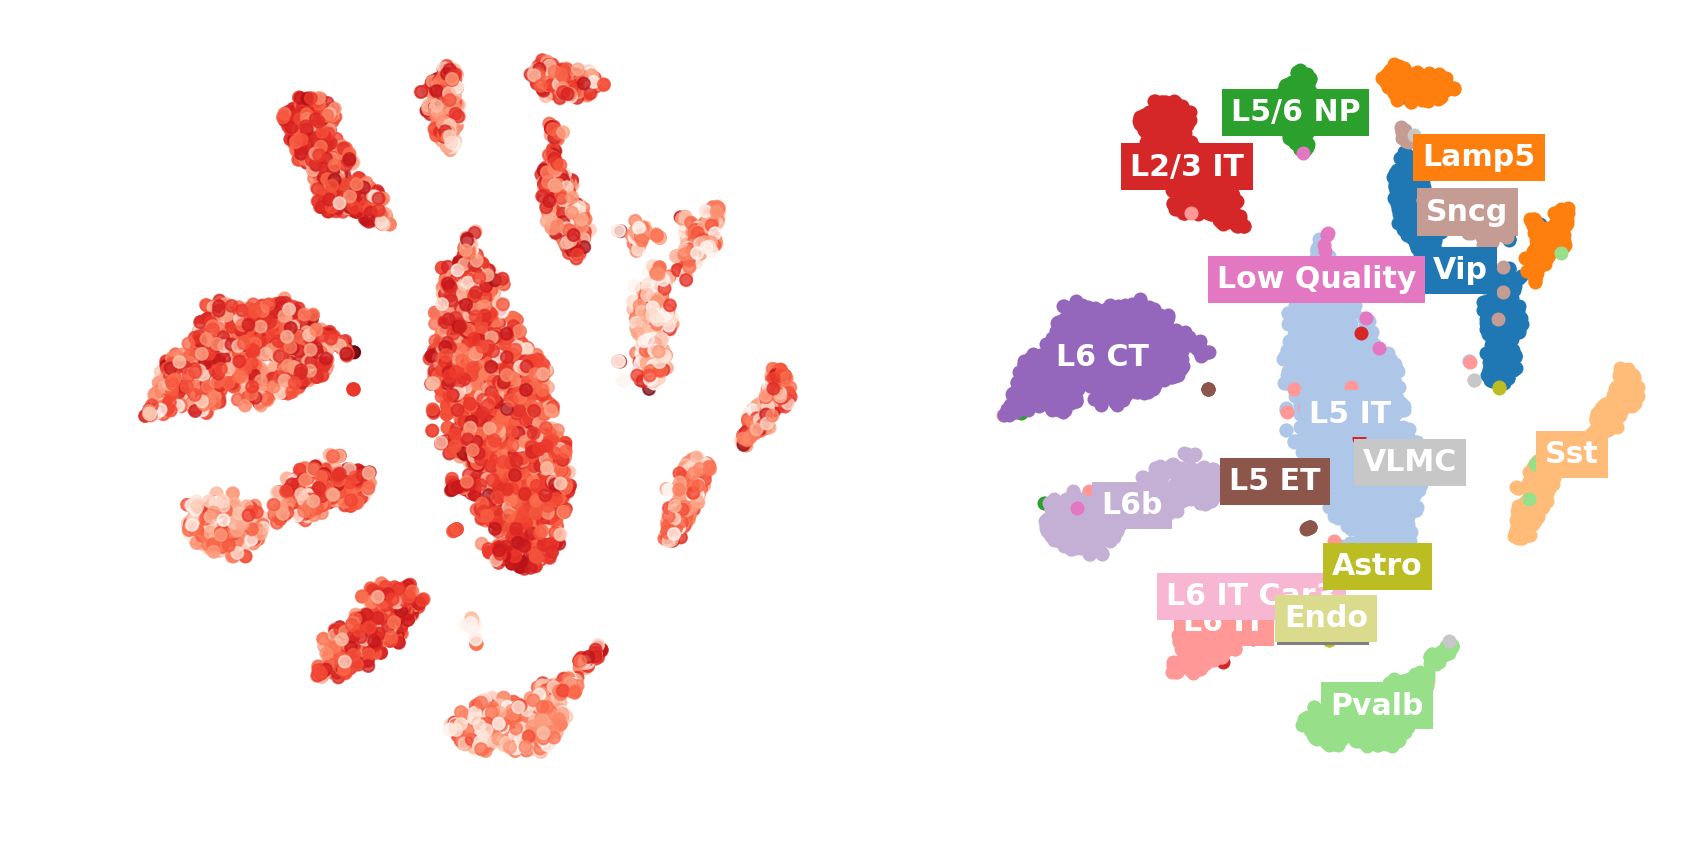

In [400]:
specific_gene = "Clasp1"#Nrgn Rorb

fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1)
cmap="Reds"
alpha = 0.75

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()

## Annotations
c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax[1].scatter(x, y, color = cmap(idx), label=cluster)
    ax[1].annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax[1].set_axis_off()

plt.show()

In [247]:
isoform.var[isoform.var.gene_name==specific_gene]

transcript_id             gene_id gene_name transcript_name  \
Tac1-205  ENSMUST00000185187  ENSMUSG00000061762      Tac1        Tac1-205   
Tac1-201  ENSMUST00000090679  ENSMUSG00000061762      Tac1        Tac1-201   
Tac1-203  ENSMUST00000184986  ENSMUSG00000061762      Tac1        Tac1-203   
Tac1-204  ENSMUST00000185130  ENSMUSG00000061762      Tac1        Tac1-204   
Tac1-202  ENSMUST00000184481  ENSMUSG00000061762      Tac1        Tac1-202   

               gene_TPM  highly_variable     means  dispersions  \
Tac1-205  603490.187500             True  4.569734     8.029018   
Tac1-201  128146.593750             True  3.048677     6.784322   
Tac1-203  148581.187500             True  3.194541     6.680249   
Tac1-204    1102.378296            False  0.163108     2.842585   
Tac1-202     278.382477             True  0.044878     4.699655   

          dispersions_norm  
Tac1-205          6.376473  
Tac1-201          4.063940  
Tac1-203          3.888578  
Tac1-204         -0.037758  
Tac1-202          1.906225

In [249]:
isoform.var[isoform.var.gene_name.str.contains("Tac")]

transcript_id             gene_id gene_name transcript_name  \
Tacr3-201    ENSMUST00000029822  ENSMUSG00000028172     Tacr3       Tacr3-201   
Tacc3-201    ENSMUST00000074849  ENSMUSG00000037313     Tacc3       Tacc3-201   
Tacc3-202    ENSMUST00000079534  ENSMUSG00000037313     Tacc3       Tacc3-202   
Tacc3-208    ENSMUST00000201633  ENSMUSG00000037313     Tacc3       Tacc3-208   
Tacc3-207    ENSMUST00000152847  ENSMUSG00000037313     Tacc3       Tacc3-207   
Tacc3-203    ENSMUST00000114426  ENSMUSG00000037313     Tacc3       Tacc3-203   
Tacc3-205    ENSMUST00000139453  ENSMUSG00000037313     Tacc3       Tacc3-205   
Tacc3-204    ENSMUST00000138240  ENSMUSG00000037313     Tacc3       Tacc3-204   
Tacc3-206    ENSMUST00000139888  ENSMUSG00000037313     Tacc3       Tacc3-206   
Tac1-205     ENSMUST00000185187  ENSMUSG00000061762      Tac1        Tac1-205   
Tac1-201     ENSMUST00000090679  ENSMUSG00000061762      Tac1        Tac1-201   
Tac1-203     ENSMUST00000184986  ENSMUSG00000061762      Tac1        Tac1-203   
Tac1-204     ENSMUST00000185130  ENSMUSG00000061762      Tac1        Tac1-204   
Tac1-202     ENSMUST00000184481  ENSMUSG00000061762      Tac1        Tac1-202   
Tacstd2-201  ENSMUST00000058178  ENSMUSG00000051397   Tacstd2     Tacstd2-201   
Tacr1-203    ENSMUST00000205041  ENSMUSG00000030043     Tacr1       Tacr1-203   
Tacr1-202    ENSMUST00000203775  ENSMUSG00000030043     Tacr1       Tacr1-202   
Tacc2-218    ENSMUST00000215492  ENSMUSG00000030852     Tacc2       Tacc2-218   
Tacc2-209    ENSMUST00000207789  ENSMUSG00000030852     Tacc2       Tacc2-209   
Tacc2-203    ENSMUST00000084513  ENSMUSG00000030852     Tacc2       Tacc2-203   
Tacc2-214    ENSMUST00000208722  ENSMUSG00000030852     Tacc2       Tacc2-214   
Tacc2-202    ENSMUST00000059145  ENSMUSG00000030852     Tacc2       Tacc2-202   
Tacc2-211    ENSMUST00000207999  ENSMUSG00000030852     Tacc2       Tacc2-211   
Tacc2-216    ENSMUST00000208882  ENSMUSG00000030852     Tacc2       Tacc2-216   
Tacc2-208    ENSMUST00000207549  ENSMUSG00000030852     Tacc2       Tacc2-208   
Tacc2-217    ENSMUST00000209108  ENSMUSG00000030852     Tacc2       Tacc2-217   
Tacc2-215    ENSMUST00000208743  ENSMUSG00000030852     Tacc2       Tacc2-215   
Tacc2-201    ENSMUST00000033141  ENSMUSG00000030852     Tacc2       Tacc2-201   
Tacc2-213    ENSMUST00000208661  ENSMUSG00000030852     Tacc2       Tacc2-213   
Tacc2-205    ENSMUST00000207282  ENSMUSG00000030852     Tacc2       Tacc2-205   
Tacc2-207    ENSMUST00000207395  ENSMUSG00000030852     Tacc2       Tacc2-207   
Tacc2-206    ENSMUST00000207376  ENSMUSG00000030852     Tacc2       Tacc2-206   
Tacc2-204    ENSMUST00000207230  ENSMUSG00000030852     Tacc2       Tacc2-204   
Tacr2-201    ENSMUST00000020278  ENSMUSG00000020081     Tacr2       Tacr2-201   
Tac2-202     ENSMUST00000179960  ENSMUSG00000025400      Tac2        Tac2-202   
Tac2-201     ENSMUST00000026466  ENSMUSG00000025400      Tac2        Tac2-201   
Tac2-203     ENSMUST00000217729  ENSMUSG00000025400      Tac2        Tac2-203   
Tac2-204     ENSMUST00000218048  ENSMUSG00000025400      Tac2        Tac2-204   
Tacc1-202    ENSMUST00000084512  ENSMUSG00000065954     Tacc1       Tacc1-202   
Tacc1-201    ENSMUST00000084030  ENSMUSG00000065954     Tacc1       Tacc1-201   
Tacc1-203    ENSMUST00000209441  ENSMUSG00000065954     Tacc1       Tacc1-203   
Tacc1-208    ENSMUST00000210645  ENSMUSG00000065954     Tacc1       Tacc1-208   
Tacc1-206    ENSMUST00000210016  ENSMUSG00000065954     Tacc1       Tacc1-206   
Tacc1-213    ENSMUST00000211622  ENSMUSG00000065954     Tacc1       Tacc1-213   
Tacc1-210    ENSMUST00000210933  ENSMUSG00000065954     Tacc1       Tacc1-210   
Tacc1-209    ENSMUST00000210767  ENSMUSG00000065954     Tacc1       Tacc1-209   
Tacc1-207    ENSMUST00000210488  ENSMUSG00000065954     Tacc1       Tacc1-207   
Tacc1-205    ENSMUST00000209827  ENSMUSG00000065954     Tacc1       Tacc1-205   
Tacc1-212    ENSMUST00000211584  ENSMUSG000000659

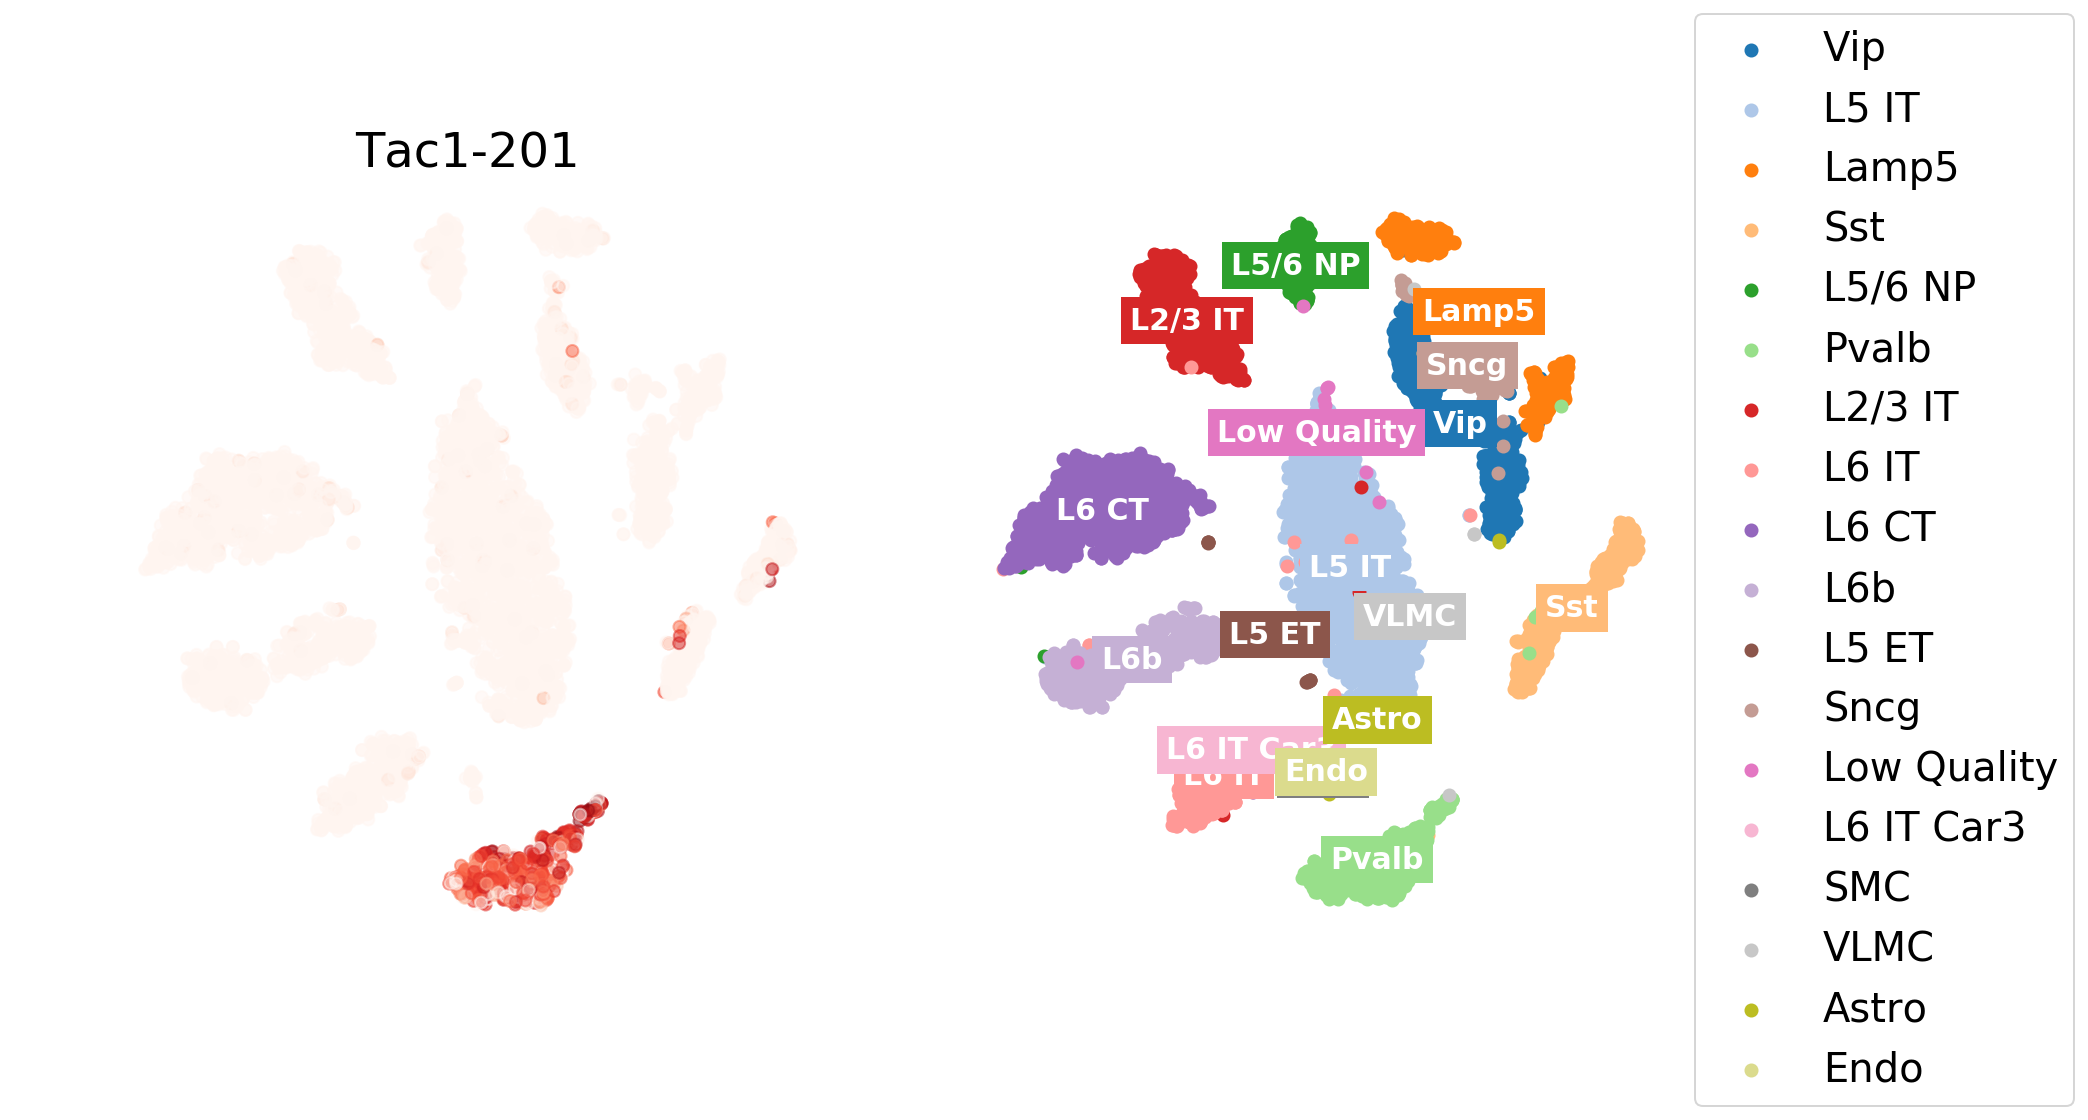

In [255]:
specific_isoform = "Tac1-201"

fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title(specific_isoform)


# Plot Class Labels
c = gene.obs["subclass_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax[1].scatter(x, y, color = cmap(idx), label=cluster)
    ax[1].annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_axis_off()

plt.show()

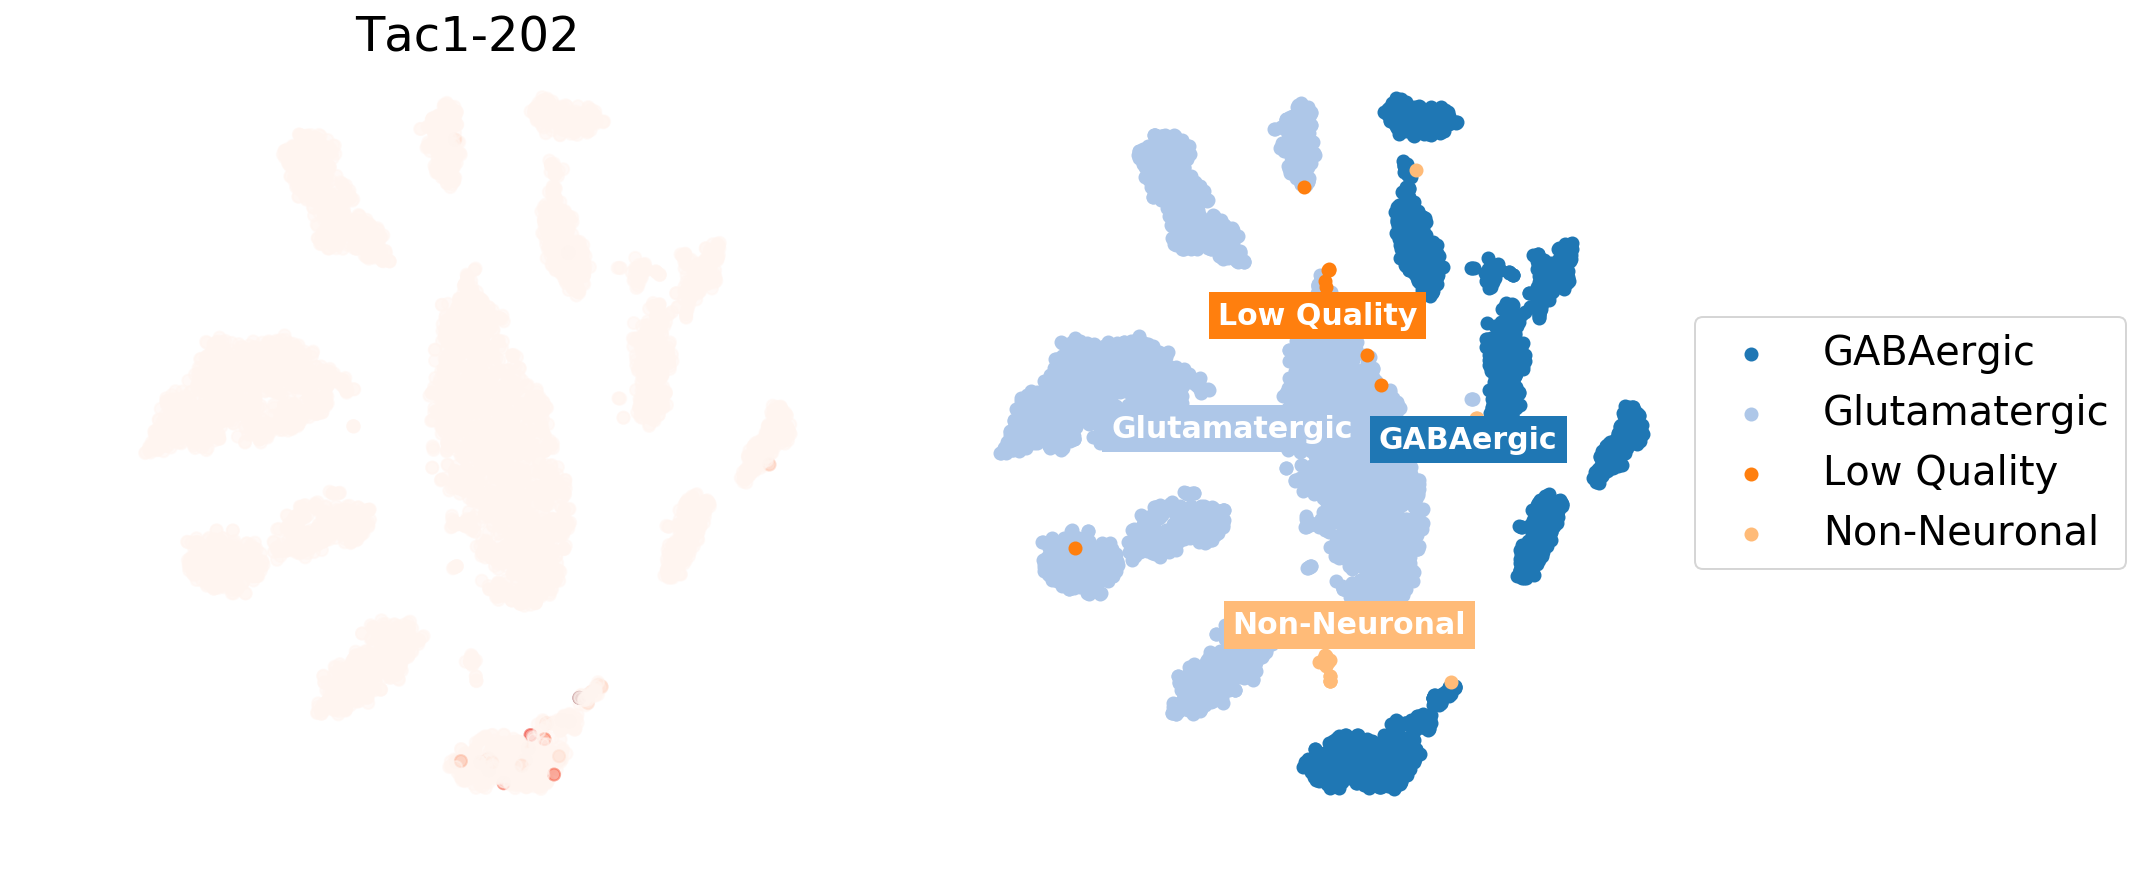

In [251]:
specific_isoform = "Tac1-202"

fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title(specific_isoform)


# Plot Class Labels
c = gene.obs["class_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.class_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax[1].scatter(x, y, color = cmap(idx), label=cluster)
    ax[1].annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_axis_off()

plt.show()

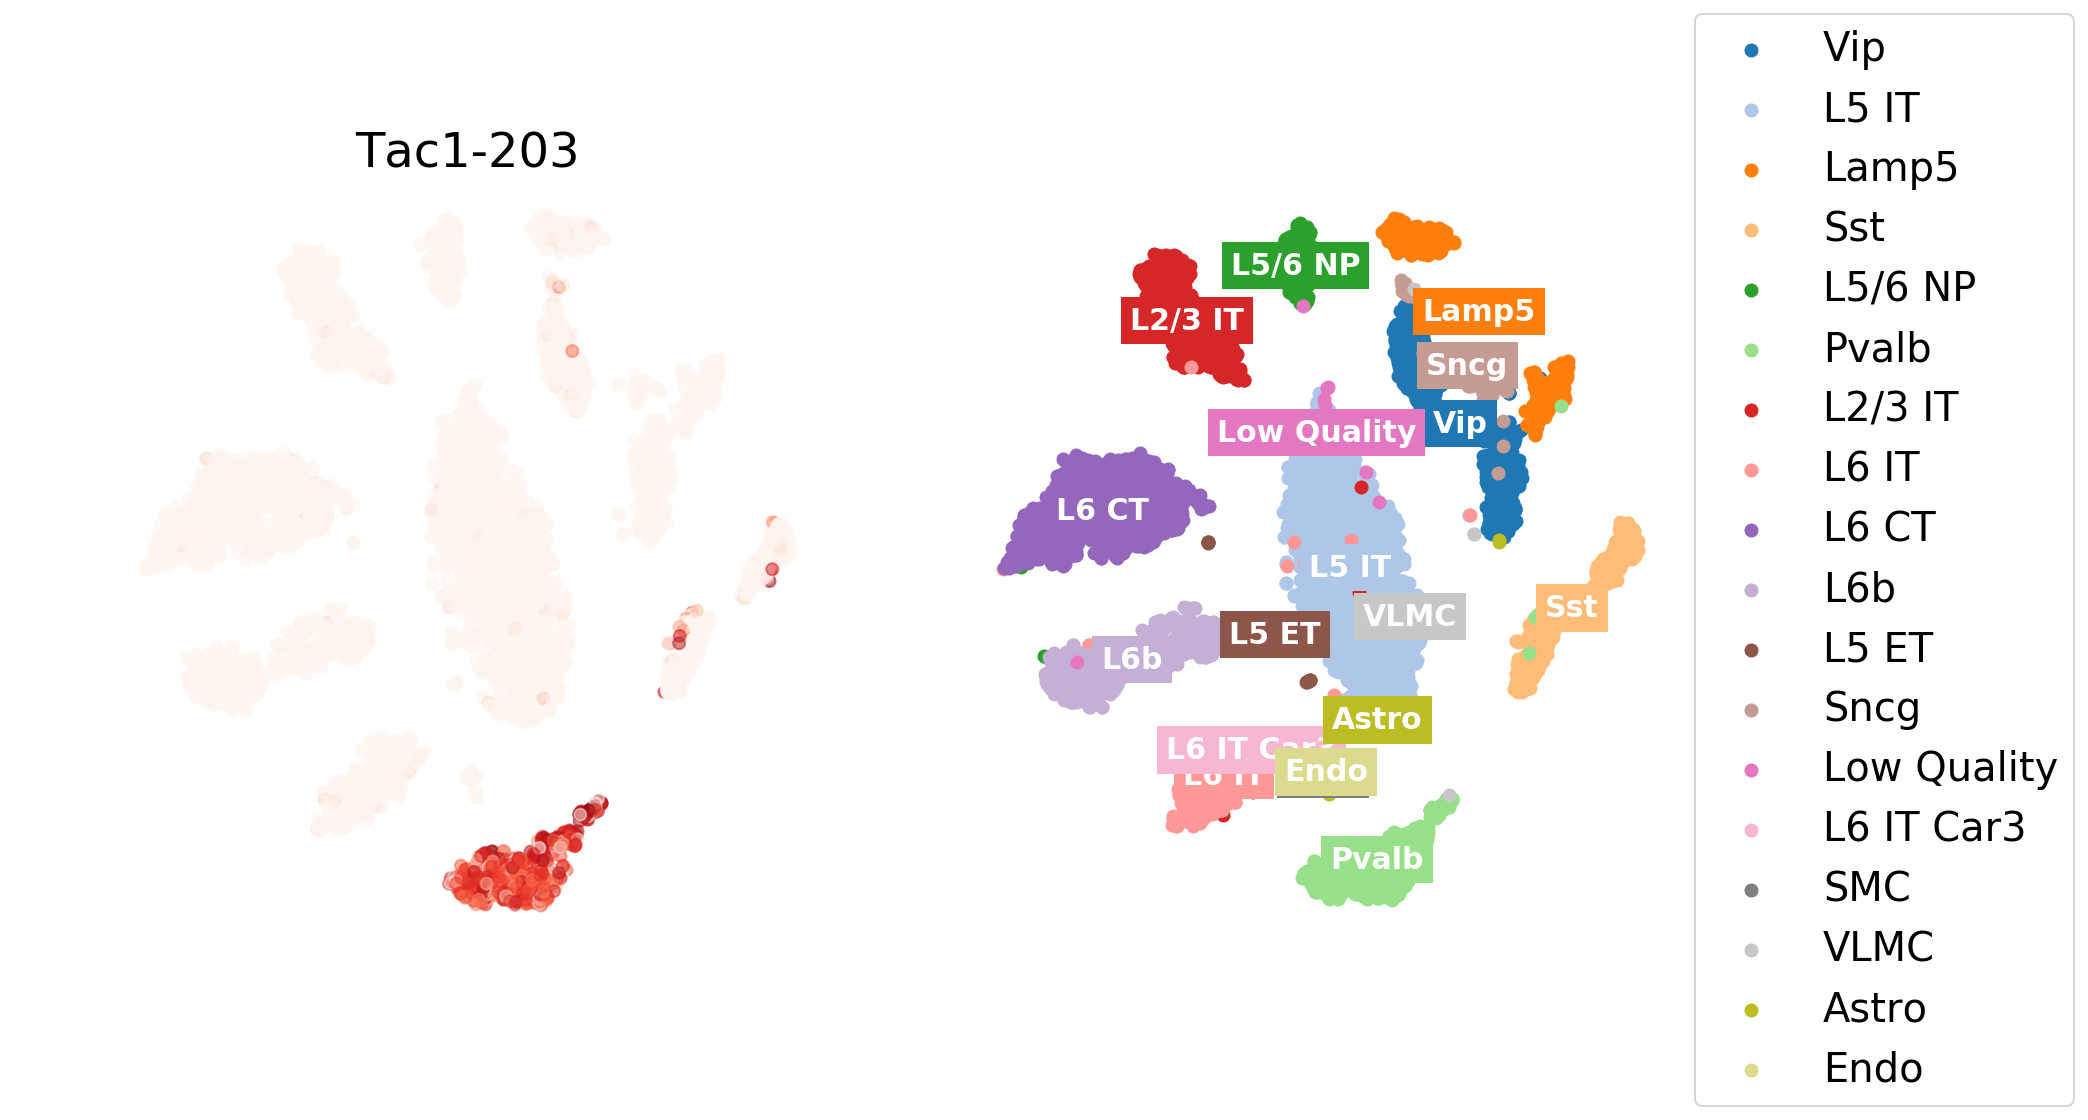

In [252]:
specific_isoform = "Tac1-203"

fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title(specific_isoform)


# Plot Class Labels
c = gene.obs["subclass_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax[1].scatter(x, y, color = cmap(idx), label=cluster)
    ax[1].annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_axis_off()

plt.show()

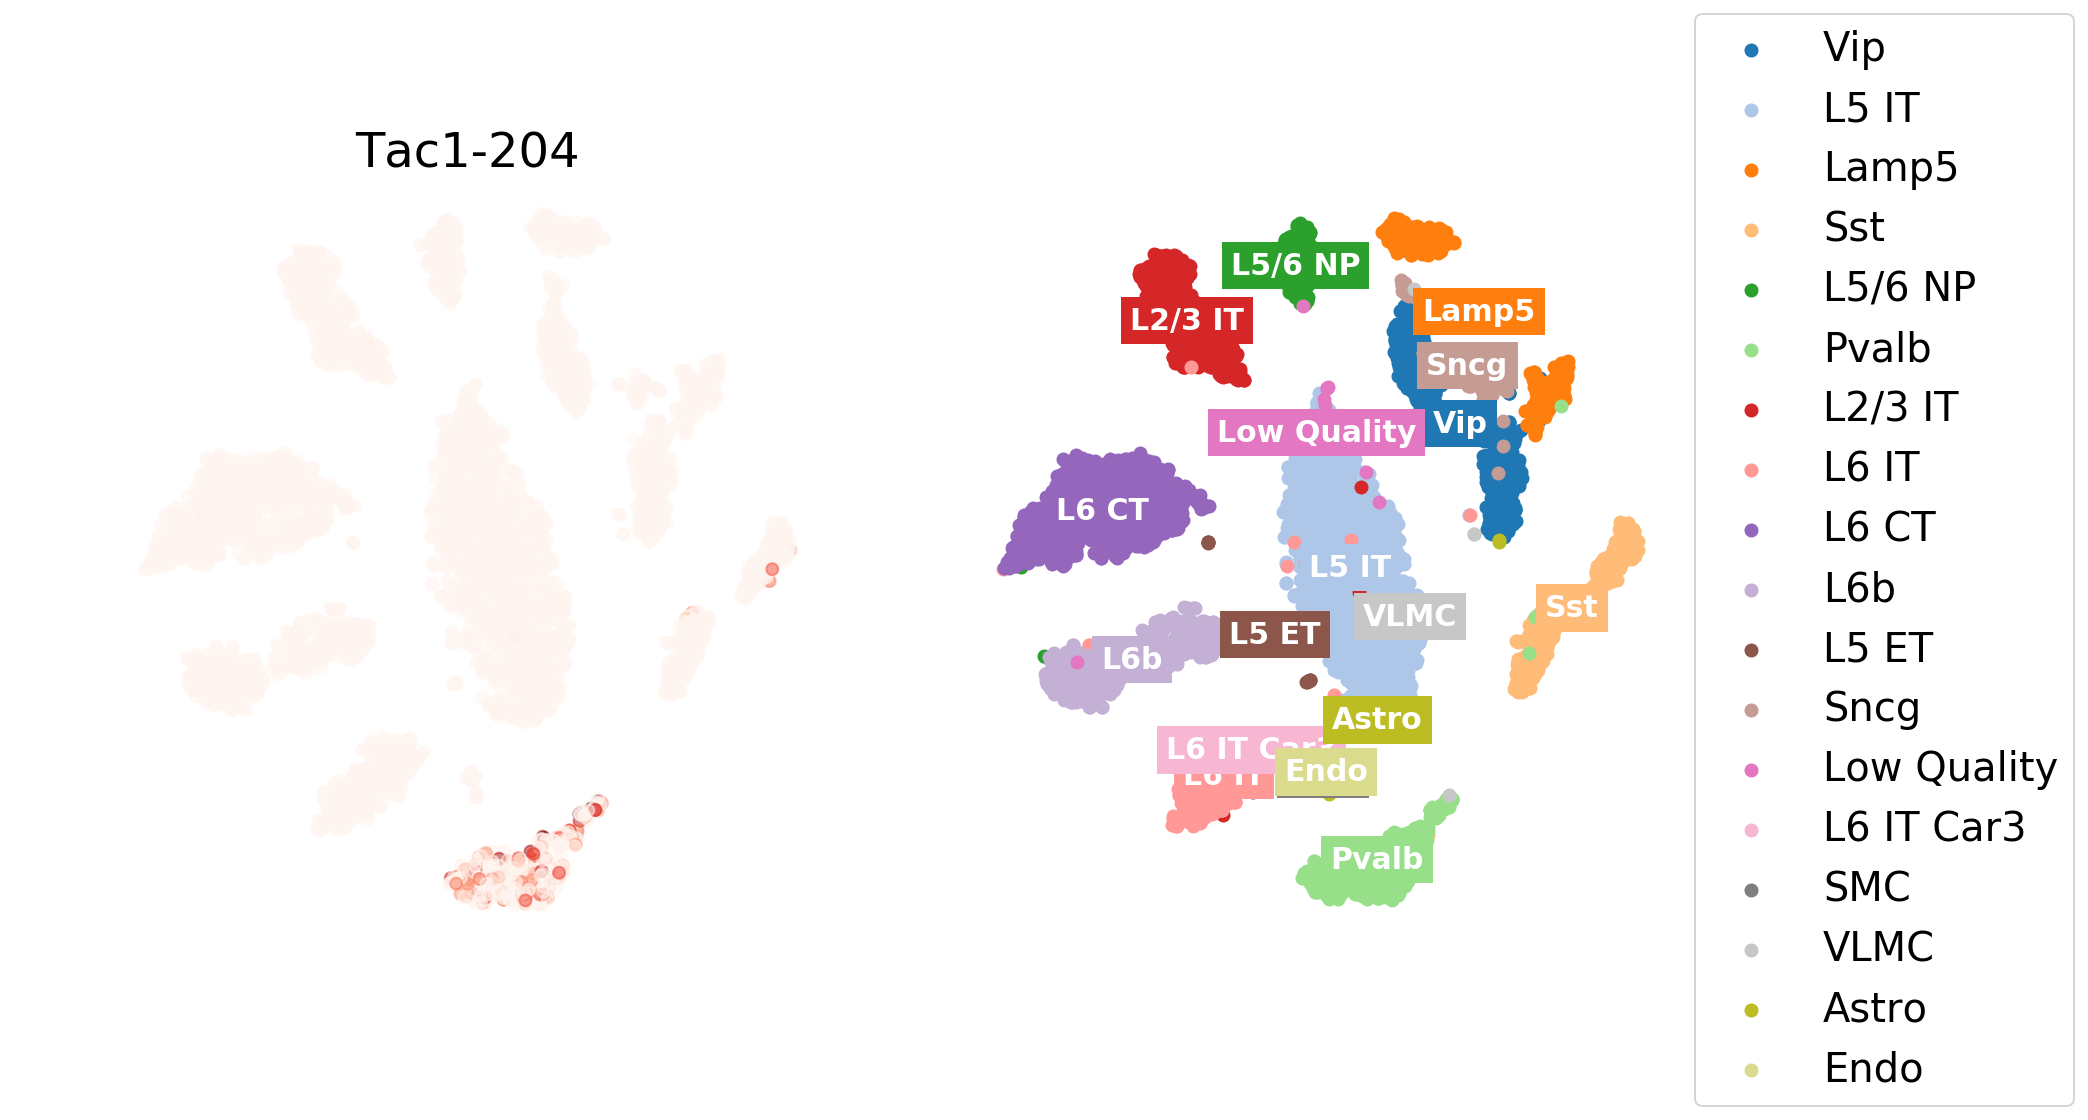

In [253]:
specific_isoform = "Tac1-204"

fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title(specific_isoform)


# Plot Class Labels
c = gene.obs["subclass_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax[1].scatter(x, y, color = cmap(idx), label=cluster)
    ax[1].annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_axis_off()

plt.show()

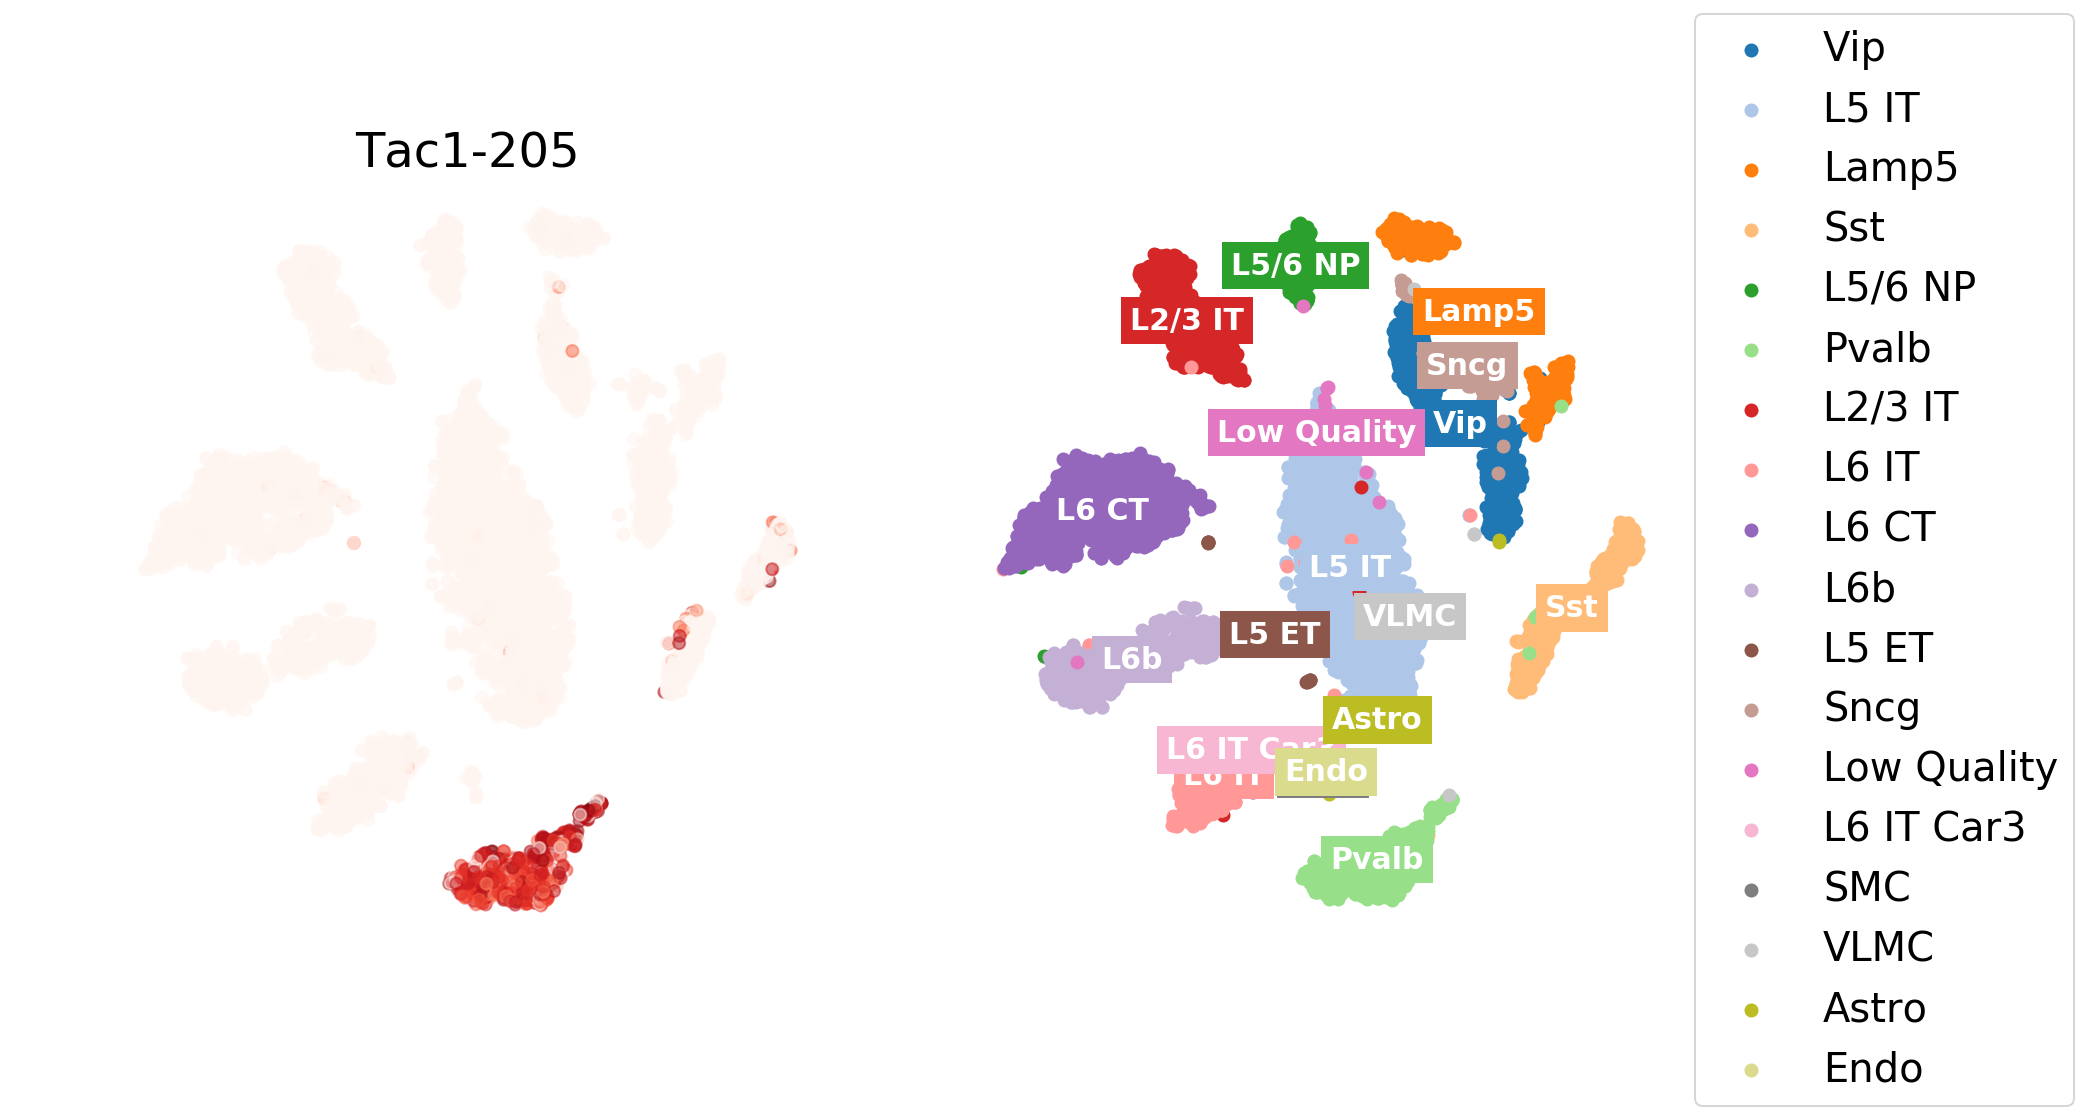

In [256]:
specific_isoform = "Tac1-205"

fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.5

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()
ax[0].set_title(specific_isoform)


# Plot Class Labels
c = gene.obs["subclass_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax[1].scatter(x, y, color = cmap(idx), label=cluster)
    ax[1].annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_axis_off()

plt.show()